# 0 环境配置

In [75]:
import os
import sys
import json
import pickle
import timeit
import random
import argparse
import cairosvg
import statistics
from statistics import mean, median
from importlib import reload
from joblib import Parallel, delayed
from collections import Counter
from functools import reduce

In [9]:
base_path = os.path.abspath('')
sys.path.append(base_path)

In [27]:
import oddt
import numpy as np
import pandas as pd
import seaborn as sns
import nglview as nv
import matplotlib.pyplot as plt
from openbabel import openbabel
from icecream import ic
from scipy import stats
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from rdkit import Chem
from rdkit import RDLogger   
from rdkit.Chem import AllChem, Draw, rdMolAlign
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Draw import DrawingOptions
from espsim.helpers import mlCharges
from pandarallel import pandarallel
from tqdm import tqdm

In [11]:
import utils.functions as fn
import utils.alignment as al
import utils.similarity as sm
import utils.metrics as mt

In [12]:
%matplotlib inline
plt.style.use('ggplot')
# plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

sns.set_theme()

RDLogger.EnableLog('rdApp.*') 

random.seed = 2022

In [18]:
reload(fn)
reload(al)
reload(sm)
reload(mt)


<module 'utils.metrics' from '/home/jovyan/work-home/molecule-3d-similarity/utils/metrics.py'>

# 1 测试

## 1.1 Mol2MolSupplier

In [ ]:
# 1 Mol2MolSupplier
database=fn.Mol2MolSupplier(os.path.join(base_path, 'demo-data/pde5a/actives_final.mol2'), sanitize=True)
len(database)

## 1.2 DUD-E Correlation

In [ ]:
# 2 auc_dude
auc_dude = 'ROCSComboscore 0.598 ± 0.152 0.681 ± 0.166 0.674 ± 0.115 0.727 ± 0.128 ROCSColorscore 0.620 ± 0.139 0.712 ± 0.159 0.677 ± 0.117 0.752 ± 0.136 ROCSShapeTanimoto 0.547 ± 0.138 0.611 ± 0.163 0.618 ± 0.105 0.667 ± 0.127 Phase Shape_Mmod 0.677 ± 0.143 0.686 ± 0.145 0.772 ± 0.105 0.769 ± 0.108 Phase Shape_Ele 0.674 ± 0.153 0.688 ± 0.158 0.753 ± 0.105 0.750 ± 0.111 Phase Shape_Pharm 0.692 ± 0.160 0.694 ± 0.168 0.761 ± 0.145 0.767 ± 0.143 Shape-it 0.541 ± 0.133 0.590 ± 0.141 0.612 ± 0.110 0.639 ± 0.115 Align-it 0.659 ± 0.137 0.680 ± 0.157 0.729 ± 0.132 0.746 ± 0.139 ShaEPbest 0.658 ± 0.122 0.660 ± 0.139 0.709 ± 0.099 0.699 ± 0.120 ShaEPshape 0.625 ± 0.139 0.632 ± 0.143 0.681 ± 0.105 0.676 ± 0.116 ShaEPESP 0.606 ± 0.109 0.591 ± 0.117 0.627 ± 0.105 0.585 ± 0.125 SHAFTS 0.733 ± 0.144 0.731 ± 0.157 0.792 ± 0.129 0.782 ± 0.135 WEGA 0.645 ± 0.143 0.659 ± 0.154 0.716 ± 0.107 0.716 ± 0.125 LIGSIFT 0.718 ± 0.133 0.755 ± 0.143 0.758 ± 0.117 0.784 ± 0.120 LS-align 0.699 ± 0.126 0.759 ± 0.119 0.773 ± 0.098 0.786 ± 0.096'
auc_dude_list = auc_dude.split(' ')
while 'Phase' in auc_dude_list:
    auc_dude_list.remove('Phase')

auc_dude_dict = []
for i in range(len(auc_dude_list)//13):
    auc_dude_dict.append([auc_dude_list[i*13]]+[float(ele) for ele in auc_dude_list[i*13+1:i*13+13:3]])

df = pd.DataFrame(auc_dude_dict)
df = df.sort_values(by=[1])
df

In [ ]:
for i in [2, 3, 4]:
    pe, pv = stats.pearsonr(df[1].to_numpy(),df[i].to_numpy())
    ic(f'pe: {pe:>10}, pv: {pv:>10}')

In [ ]:
pccs = np.corrcoef([df[i].to_numpy() for i in [1,2,3,4]])
ic(pccs)

In [ ]:
sns.heatmap(pccs)

In [ ]:
plt.figure(figsize=(5, 5), dpi=200)
for i in [1,2,3,4]:
    plt.scatter(list(range(df.shape[0])), df[i].tolist())

## 1.3 去重

In [ ]:
# table = Chem.GetPeriodicTable()

# # for ele in [14, 16, 19]:
# #     ligand.GetAtomWithIdx(ele).SetNumExplicitHs(1)
# ligand = Chem.RemoveAllHs(ligand, sanitize=True)
# ligand.RemoveAllConformers()
# for atom in ligand.GetAtoms():
#     if atom.GetTotalValence() != table.GetDefaultValence(atom.GetAtomicNum()):
#         atom.SetFormalCharge(atom.GetTotalValence()-table.GetDefaultValence(atom.GetAtomMapNum()))
# Chem.SanitizeMol(ligand)
# ligand

In [ ]:
m1 = Chem.MolFromMol2File(os.path.join(base_path, f'demo-data/pde5a/crystal_ligand.mol2'))
m2 = Chem.MolFromSmiles('CCCc1nn(c2c1nc([nH]c2=O)c1cc(ccc1OCC)S(=O)(=O)n1ccn(cc1)C)C')

In [ ]:
m1.RemoveAllConformers()
m1

In [ ]:
m2

In [ ]:
ic(Chem.MolToInchiKey(m1))
ic(Chem.MolToInchiKey(m2))
ic(Chem.MolToSmiles(m1))
ic(Chem.MolToSmiles(m2))

## 1.4 绘图

In [ ]:
# parser = argparse.ArgumentParser( 'smiles to png inmage' )
# parser.add_argument( 'smiles' )
# parser.add_argument( '--filename', default="mol." )
 
# parser.add_argument( 'smiles' )
 
# param = parser.parse_args()
# smiles = param.smiles
# fname = param.filename


In [ ]:
def draw_mol(mol, save_dir, fname):
    DrawingOptions.atomLabelFontSize = 55
    DrawingOptions.dotsPerAngstrom = 100
    DrawingOptions.bondLineWidth = 3.0

    Draw.MolToFile(mol, os.path.join(save_dir, fname+".png"))
    Draw.MolToFile(mol, os.path.join(save_dir, fname+'.svg'))
    cairosvg.svg2png(url=os.path.join(save_dir, fname+'.svg'), write_to= os.path.join(save_dir, "svg_"+fname+".png"))

In [ ]:
draw_mol(m1, '/home/jovyan/work-home/DUD-E/src/img', 'pde5a_cry_lig')

# 2 DUD-E

In [13]:
dude_dir = 'dude/all'
n_jobs = 8

In [14]:
target_list = ['pde5a', 'akt1', 'ada', 'andr', 'def', 'gria2', 'egfr', 'gcr', 'igf1r']
target_flag = 6
target_list[target_flag]

'egfr'

In [8]:
gz_a_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'actives_final.sdf.gz')
gz_d_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'decoys_final.sdf.gz')
for gz_path in [gz_a_path, gz_d_path]:
    if os.path.exists(gz_path):
        os.system(f"gzip -d {gz_path}")

In [9]:
# decoys_path 
d_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'decoys_final.sdf')
# actives_path 
a_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'actives_final.sdf')
# target_rec = os.path.join(base_path, f'demo-data/{target_list[target_flag]}/receptor_FH.pdb')
# ligand_path 
l_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'crystal_ligand.mol2')

## 2.0 数据去重

In [ ]:
# act_405 = [mol for mol in act if mol.title=='CHEMBL405920']
act_405_path = os.path.join(base_path, dude_dir, 'ada', 'actives_CHE405.mol2')
# w = oddt.toolkits.rdk.Outputfile('mol2', act_405_path, overwrite=True)
# for m in act_405:
#     m.Mol = ''
#     w.write(m)
# w.close()
act_405 = fn.Mol2MolSupplier(act_405_path, sanitize=True)
Draw.MolsToGridImage(act_405, molsPerRow=8, subImgSize=(150,150), legends=[mol.GetProp('_Name') for mol in act_405],maxMols=100)

In [ ]:
# act = fn.Mol2MolSupplier(a_path.split('.')[0]+'.mol2', sanitize=True)
# dec = fn.Mol2MolSupplier(d_path.split('.')[0]+'.mol2', sanitize=True)
act = [m for m in Chem.SDMolSupplier(a_path, removeHs=False) if m]
dec = [m for m in Chem.SDMolSupplier(d_path, removeHs=False) if m]

ic(len(act))
ic(len(dec))

In [ ]:
def de_duplicate(m_list):
    name_l = []
    inck_l = []
    de_m_l = []

    for m in m_list:
        name = m.GetProp('_Name')
        inck = Chem.MolToInchiKey(m)
        if name in name_l:
            # ic('name duplicate')
            pass
        elif inck in inck_l:
            # ic('icnk duplicate')
            pass
        else:
            name_l.append(name)
            inck_l.append(inck)
            de_m_l.append(m)
    
    return de_m_l

In [ ]:
act_dd = de_duplicate(act)
ic(len(act_dd))
with Chem.SDWriter(os.path.join(base_path, dude_dir, target_list[target_flag], 'actives_dd.sdf')) as w:
    for m in act_dd:
        w.write(m)

In [ ]:
dec_dd = de_duplicate(dec)
ic(len(dec_dd))
with Chem.SDWriter(os.path.join(base_path, dude_dir, target_list[target_flag], 'decoys_dd.sdf')) as w:
    for m in dec_dd:
        w.write(m)

In [ ]:
a_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'actives_dd.sdf')
d_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'decoys_dd.sdf')

In [ ]:
def sdf2mol2(sdf_path, mol_path):
    sdf_l = [mol for mol in list(oddt.toolkit.readfile('sdf', sdf_path)) if mol]
    w = oddt.toolkits.rdk.Outputfile('mol2', mol_path, overwrite=True)
    for m in sdf_l:
        m.Mol = ''
        w.write(m)
    w.close()

In [ ]:
sdf2mol2(a_path, a_path.split('.')[0]+'.mol2')
sdf2mol2(d_path, d_path.split('.')[0]+'.mol2')

In [ ]:
t_l = [mol for mol in list(oddt.toolkit.readfile('mol2',a_path.split('.')[0]+'.mol2')) if mol]
len(t_l)

In [ ]:
# m = AllChem.MolFromSmiles('c1ccc(cc1)COC(=O)c1cc2c(c(c1)CCN1C=NC3=C1NC=[NH]C[C@@H]3O)CCCC2')
# type(m)

## 2.1 数据加载

In [10]:
a_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'actives_dd.sdf')
d_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'decoys_dd.sdf')
l_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'crystal_ligand.mol2')
ic(a_path)

# decoys = fn.Mol2MolSupplier(d_path, sanitize=True)
decoys = [m for m in Chem.SDMolSupplier(d_path, removeHs=False) if m]
ic(len(decoys))
Draw.MolsToGridImage(random.sample(decoys, 7), molsPerRow=7, subImgSize=(150,150), legends=[mol.GetProp('_Name') for mol in decoys[:7]],maxMols=100)

actives = [m for m in Chem.SDMolSupplier(a_path, removeHs=False) if m]
ic(len(actives))
Draw.MolsToGridImage(random.sample(actives, 7), molsPerRow=7, subImgSize=(150,150), legends=[mol.GetProp('_Name') for mol in actives[:7]],maxMols=100)

ligand = AllChem.MolFromMol2File(l_path, removeHs=False)
ligand = Chem.AddHs(ligand, addCoords=True)
ligand

ic| a_path: '/home/jovyan/work-home/molecule-3d-similarity/dude/all/igf1r/actives_dd.sdf'


'/home/jovyan/work-home/molecule-3d-similarity/dude/all/igf1r/actives_dd.sdf'

## 2.1 RDKIT

### 2.1.1 测试分子对齐

In [ ]:
prbs, actives_o3a_score = al.rdkit_o3a(actives[10:20], ligand, n_jobs=32)
statistics.mean(actives_o3a_score)

In [ ]:
view = fn.show_ligands([ligand]+prbs)
view

In [ ]:
actives_crippeno3a_score = al.rdkit_crippeno3a(actives[:10], ligand)
statistics.mean(actives_crippeno3a_score)

In [ ]:
view = fn.show_ligands([ligand]+actives[:10])
view

In [ ]:
# rmsd = rdkit_alignmol(actives[:10], ligand)
# statistics.mean(rmsd)
# # RuntimeError: No sub-structure match found between the probe and query mol

In [ ]:
decoys_o3a_score = al.rdkit_o3a(decoys[:10], ligand)
statistics.mean(decoys_o3a_score)

In [ ]:
view = fn.show_ligands([ligand]+decoys[:10])
view

In [ ]:
decoys_crippeno3a_score = al.rdkit_crippeno3a(decoys[:10], ligand)
statistics.mean(decoys_crippeno3a_score)

In [ ]:
view = fn.show_ligands([ligand]+decoys[:10])
view

In [ ]:
prb_crippen = [Chem.rdMolDescriptors._CalcCrippenContribs(mol) for mol in actives[:10]]
ref_crippen = Chem.rdMolDescriptors._CalcCrippenContribs(ligand)

In [ ]:
actives_crippeno3a_score = al.rdkit_crippeno3a(actives[:10], ligand, prb_crippen=prb_crippen, ref_crippen=ref_crippen)
statistics.mean(actives_crippeno3a_score)

In [ ]:
# prb_mmff = [AllChem.MMFFGetMoleculeProperties(mol) for mol in actives[0:10]]
# ref_mmff = AllChem.MMFFGetMoleculeProperties(ligand)
# decoys_o3a_score = rdkit_o3a(decoys[:10], ligand, prb_mmff=prb_mmff, ref_mmff=ref_mmff)
# statistics.mean(decoys_o3a_score)
# # RuntimeError: Invariant Violation
# # 	Negative weight specified for a point
# # 	Violation occurred on line 57 in file Code/Numerics/Alignment/AlignPoints.cpp
# # 	Failed Expression: wData[i] > 0.0
# # 	RDKIT: 2022.03.4
# # 	BOOST: 1_74

### 2.1.2 分子三维结构相似度计算

In [16]:
# actives_sampled = random.sample(actives, 100)
# decoys_sampled = random.sample(decoys, 500)
# RDLogger.DisableLog('rdApp.*') 
RDLogger.EnableLog('rdApp.*')

In [17]:
# actives_sampled_path = os.path.join(base_path, 'demo-data/pde5a/actives_sample_100.sdf')
# decoys_sampled_path = os.path.join(base_path, 'demo-data/pde5a/decoys_sample_500.sdf')


In [18]:
# writer = Chem.SDWriter(actives_sampled_path)
# for cid in range(len(actives_sampled)):
#     writer.write(actives_sampled[cid])
    
# writer = Chem.SDWriter(decoys_sampled_path)
# for cid in range(len(decoys_sampled)):
#     writer.write(decoys_sampled[cid])

In [19]:
from sklearn.metrics import dcg_score


# actives = [m for m in Chem.SDMolSupplier(actives_sampled_path) if m]
# decoys = [m for m in Chem.SDMolSupplier(decoys_sampled_path) if m]
# ligand = AllChem.MolFromMol2File(l_path)

len_a = len(actives)
len_d = len(decoys)
ic(len_a)
ic(len_d)

ic| len_a: 148
ic| len_d: 9286


9286

In [20]:
a_o_a_time = 0
start = timeit.default_timer()
actives_o, align_score =al.rdkit_o3a(actives, ligand, n_jobs=n_jobs, verbose=1)
end = timeit.default_timer()
a_o_a_time = end - start
ic(a_o_a_time)
a_o_d_time = 0
start = timeit.default_timer()
decoys_o, align_score =al.rdkit_o3a(decoys, ligand, n_jobs=n_jobs, verbose=1)
end = timeit.default_timer()
a_o_d_time = end - start
ic(a_o_d_time)

a_c_a_time = 0
start = timeit.default_timer()
actives_c, align_score =al.rdkit_crippeno3a(actives, ligand, n_jobs=n_jobs, verbose=1)
end = timeit.default_timer()
a_c_a_time = end - start
ic(a_c_a_time)
a_c_d_time = 0
start = timeit.default_timer()
decoys_c, align_score =al.rdkit_crippeno3a(decoys, ligand, n_jobs=n_jobs, verbose=1)
end = timeit.default_timer()
a_c_d_time = end - start
ic(a_c_d_time)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    1.3s finished
ic| a_o_a_time: 1.3225933029316366
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1200 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done 3200 tasks      | elapsed:   11.5s
[Parallel(n_jobs=8)]: Done 6000 tasks      | elapsed:   20.4s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:   31.7s finished
ic| a_o_d_time: 31.657450501807034
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.4s finished
ic| a_c_a_time: 0.3660201020538807
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jo

16.692637834697962

In [ ]:
# writer = Chem.SDWriter(actives_sampled_path)
# for cid in range(len(actives_sampled)):
#     actives_sampled[cid].SetProp('_Name', f'activeInChIKey{Chem.MolToInchiKey(actives_sampled[cid])}')
#     writer.write(actives_sampled[cid])
    
# writer = Chem.SDWriter(decoys_sampled_path)
# for cid in range(len(decoys_sampled)):
#     decoys_sampled[cid].SetProp('_Name', f'InChIKey{Chem.MolToInchiKey(decoys_sampled[cid])}')
#     writer.write(decoys_sampled[cid])

In [ ]:
# sampled_path = os.path.join(base_path, 'demo-data/pde5a/sample_600.sdf')
# writer = Chem.SDWriter(sampled_path)
# for cid in range(len(actives)):
#     writer.write(actives[cid])
# for cid in range(len(decoys)):
#     writer.write(decoys[cid])

In [ ]:
# actives = actives[:10]
# decoys = decoys[:50]
# lan_a = len(actives)
# len_d = len(decoys)

In [21]:
def toy_test_similarity(s_func, prb_mols, ref_mol, align_time=0):
    start = timeit.default_timer()
    similarity_list = s_func(prb_mols, ref_mol, n_jobs=n_jobs, verbose=1)
    end = timeit.default_timer()

    print(f'mean   : {mean(similarity_list)}')
    print(f'median : {median(similarity_list)}')
    time = len(prb_mols) / (end - start + align_time)
    return similarity_list, time

In [22]:
sim_dict = dict()
tim_dict = dict()

In [23]:
similarity_methods = {
    'rdkit_protrude': sm.rdkit_shape_protrude_dist, 
    'rdkit_tanimoto': sm.rdkit_shape_tanimoto_dist,
    'rdkit_tversky': sm.rdkit_shape_tversky_index,
    'rdkit_sc': sm.rdkit_sc_score,
    'rdkit_sc_tanimoto': sm.rdkit_sc_score_tanimoto,
    'rdkit_sc_tversky': sm.rdkit_sc_score_tversky,
}

for name, func in similarity_methods.items():
    _name = name
    name = _name + '-o3a'    
    print(f'🌟 {name} 🌟')
    result_tmp = sim_dict.get(name, [])
    t_tmp = tim_dict.get(name, [])
    print('----👇 actives 👇----')
    similarity_score, time_a = toy_test_similarity(func, actives_o, ligand, a_o_a_time)
    result_tmp += [(ele, 1) for ele in similarity_score]
    t_tmp.append(time_a)
    print('----👇 decoys 👇----')
    similarity_score, time_d = toy_test_similarity(func, decoys_o, ligand, a_o_d_time)
    result_tmp += [(ele, 0) for ele in similarity_score]
    t_tmp.append(time_d)
    # assert len(result_tmp) == 600, f"len(result_tmp) = {len(result_tmp)}"
    sim_dict[name] = result_tmp
    tim_dict[name] = t_tmp
    print(f'speed: {mean([time_a, time_d])}')


    name = _name + '-crippeno3a'
    print(f'🌟 {name} 🌟')
    result_tmp = sim_dict.get(name, [])
    t_tmp = tim_dict.get(name, [])
    print('----👇 actives 👇----')
    similarity_score, time_a = toy_test_similarity(func, actives_c, ligand, a_c_a_time)
    result_tmp += [(ele, 1) for ele in similarity_score]
    t_tmp.append(time_a)
    print('----👇 decoys 👇----')
    similarity_score, time_d = toy_test_similarity(func, decoys_c, ligand, a_c_d_time)
    result_tmp += [(ele, 0) for ele in similarity_score]
    t_tmp.append(time_d)
    # assert len(result_tmp) == 600, f"len(result_tmp) = {len(result_tmp)}"
    sim_dict[name] = result_tmp
    tim_dict[name] = t_tmp
    print(f'speed: {mean([time_a, time_d])}')

🌟 rdkit_protrude-o3a 🌟
----👇 actives 👇----
mean   : 0.4883480190444232
median : 0.48489765844941674
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 8453 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


mean   : 0.4866194625236653
median : 0.48079779494409075
speed: 192.8358608678687
🌟 rdkit_protrude-crippeno3a 🌟
----👇 actives 👇----
mean   : 0.4906766636553716
median : 0.4896685696979815
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 8696 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


mean   : 0.48513945167444156
median : 0.47860174160603347
speed: 418.5904858849782
🌟 rdkit_tanimoto-o3a 🌟
----👇 actives 👇----
mean   : 0.36852384333013544
median : 0.35777025795202927
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 8210 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


mean   : 0.3477709610035297
median : 0.34561173577775595
speed: 192.81286237996858
🌟 rdkit_tanimoto-crippeno3a 🌟
----👇 actives 👇----
mean   : 0.3707564504956951
median : 0.3678019850034846
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 8453 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


mean   : 0.34628531013977887
median : 0.34382726373747446
speed: 418.3792883025614
🌟 rdkit_tversky-o3a 🌟
----👇 actives 👇----
mean   : 0.5139969173207634
median : 0.5137661855698181
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 8453 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


mean   : 0.5017619714146989
median : 0.5001894405418436
speed: 192.83395607492884
🌟 rdkit_tversky-crippeno3a 🌟
----👇 actives 👇----
mean   : 0.5165636443623793
median : 0.5189540013453897
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 8210 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:    1.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


mean   : 0.5001841899700256
median : 0.4983323057572988
speed: 415.77163183378786
🌟 rdkit_sc-o3a 🌟
----👇 actives 👇----


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 133 out of 148 | elapsed:    1.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    1.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


mean   : 0.3510452020213528
median : 0.32101747844354606
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 1200 tasks      | elapsed:    5.1s
[Parallel(n_jobs=8)]: Done 3200 tasks      | elapsed:   13.4s
[Parallel(n_jobs=8)]: Done 6000 tasks      | elapsed:   24.5s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:   38.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


mean   : 0.3116666436417263
median : 0.3055670393290416
speed: 95.62840385373033
🌟 rdkit_sc-crippeno3a 🌟
----👇 actives 👇----


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


mean   : 0.35509180319174494
median : 0.3268892137692958
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1200 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 3200 tasks      | elapsed:   13.3s
[Parallel(n_jobs=8)]: Done 6000 tasks      | elapsed:   24.6s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:   38.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


mean   : 0.3097774724204109
median : 0.30255002030058575
speed: 152.00187358852722
🌟 rdkit_sc_tanimoto-o3a 🌟
----👇 actives 👇----


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


mean   : 0.2911331141642089
median : 0.2624122220883289
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1200 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 3200 tasks      | elapsed:   13.3s
[Parallel(n_jobs=8)]: Done 6000 tasks      | elapsed:   24.4s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:   37.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


mean   : 0.24224239288165852
median : 0.23749426556109035
speed: 102.9825372615554
🌟 rdkit_sc_tanimoto-crippeno3a 🌟
----👇 actives 👇----


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 133 out of 148 | elapsed:    0.8s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


mean   : 0.2951316966119067
median : 0.26664075181928537
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 656 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 1656 tasks      | elapsed:    7.0s
[Parallel(n_jobs=8)]: Done 3056 tasks      | elapsed:   13.0s
[Parallel(n_jobs=8)]: Done 4856 tasks      | elapsed:   20.4s
[Parallel(n_jobs=8)]: Done 7056 tasks      | elapsed:   29.5s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:   39.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


mean   : 0.24035040165307958
median : 0.2350817250021187
speed: 146.44983854813094
🌟 rdkit_sc_tversky-o3a 🌟
----👇 actives 👇----


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


mean   : 0.36386965115952286
median : 0.33570948503358433
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1200 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 3200 tasks      | elapsed:   13.2s
[Parallel(n_jobs=8)]: Done 6000 tasks      | elapsed:   24.5s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:   38.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


mean   : 0.31923789808724307
median : 0.31476727777388513
speed: 102.33332281052476
🌟 rdkit_sc_tversky-crippeno3a 🌟
----👇 actives 👇----


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 133 out of 148 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


mean   : 0.3680352935452488
median : 0.3397064950849611
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1200 tasks      | elapsed:    4.9s
[Parallel(n_jobs=8)]: Done 3200 tasks      | elapsed:   13.3s
[Parallel(n_jobs=8)]: Done 6000 tasks      | elapsed:   24.8s


mean   : 0.31729984156820296
median : 0.3118668859535442
speed: 149.31419348555374


[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:   38.6s finished


In [24]:
similarity_methods = {
    'rdkit_pharm_tanimoto': sm.rdkit_pharm_tanimoto,
    'rdkit_pharm_tversky': sm.rdkit_pharm_tversky,
    'rdkit_fp_maccs': sm.rdkit_fp_maccs,
    'rdkit_fp_maccs_tanimoto': sm.rdkit_fp_maccs_tainimoto,
    'rdkit_fp_maccs_tversky': sm.rdkit_fp_maccs_tversky,
    'rdkit_fp_margan': sm.rdkit_fp_morgan,
    'rdkit_fp_margan_tanimoto': sm.rdkit_fp_morgan_tanimoto,
    'rdkit_fp_margan_tversky': sm.rdkit_fp_morgan_tversky,
}

for name, func in similarity_methods.items():  
    print(f'🌟 {name} 🌟')
    result_tmp = sim_dict.get(name, [])
    t_tmp = tim_dict.get(name, [])
    print('----👇 actives 👇----')
    similarity_score, time_a = toy_test_similarity(func, actives, ligand)
    result_tmp += [(ele, 1) for ele in similarity_score]
    t_tmp.append(time_a)
    print('----👇 decoys 👇----')
    similarity_score, time_d = toy_test_similarity(func, decoys, ligand)
    result_tmp += [(ele, 0) for ele in similarity_score]
    t_tmp.append(time_d)
    # assert len(result_tmp) == 600, f"len(result_tmp) = {len(result_tmp)}"
    sim_dict[name] = result_tmp
    tim_dict[name] = t_tmp
    print(f'speed: {mean([time_a, time_d])}')


🌟 rdkit_pharm_tanimoto 🌟
----👇 actives 👇----


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:   13.6s finished


mean   : 0.3808933196280874
median : 0.40492728065560746
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    4.5s
[Parallel(n_jobs=8)]: Done 1288 tasks      | elapsed:   18.2s
[Parallel(n_jobs=8)]: Done 2304 tasks      | elapsed:   35.1s
[Parallel(n_jobs=8)]: Done 3688 tasks      | elapsed:   55.5s
[Parallel(n_jobs=8)]: Done 5314 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 7644 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 9144 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 9271 out of 9286 | elapsed:  2.4min remaining:    0.2s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:  2.4min finished


mean   : 0.18808458856170573
median : 0.17503281859993233
speed: 36.74560498134854
🌟 rdkit_pharm_tversky 🌟
----👇 actives 👇----


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:   13.5s finished


mean   : 0.5599771167823996
median : 0.5800645218794186
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  52 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 352 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 1288 tasks      | elapsed:   18.0s
[Parallel(n_jobs=8)]: Done 2304 tasks      | elapsed:   34.7s
[Parallel(n_jobs=8)]: Done 3664 tasks      | elapsed:   55.0s
[Parallel(n_jobs=8)]: Done 5304 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 7618 tasks      | elapsed:  1.9min
[Parallel(n_jobs=8)]: Done 9112 tasks      | elapsed:  2.4min
[Parallel(n_jobs=8)]: Done 9271 out of 9286 | elapsed:  2.4min remaining:    0.2s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:  2.4min finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent worke

mean   : 0.27768434022001875
median : 0.2677549003352986
speed: 36.90691819089576
🌟 rdkit_fp_maccs 🌟
----👇 actives 👇----
mean   : 0.623233600380054
median : 0.6370223978919631
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done 8454 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s


mean   : 0.5132095979571171
median : 0.525
speed: 2913.661443420541
🌟 rdkit_fp_maccs_tanimoto 🌟
----👇 actives 👇----
mean   : 0.623233600380054
median : 0.6370223978919631
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 8454 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:    2.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


mean   : 0.5132095979571171
median : 0.525
speed: 2767.8041260175896
🌟 rdkit_fp_maccs_tversky 🌟
----👇 actives 👇----
mean   : 0.7983393347738218
median : 0.8105619431586283
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 8454 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s


mean   : 0.7072347140997749
median : 0.7253886010362696
speed: 3126.3535800790487
🌟 rdkit_fp_margan 🌟
----👇 actives 👇----
mean   : 0.4674340450857132
median : 0.4464446206714248
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 8696 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


mean   : 0.39616211436405574
median : 0.40425531914893614
speed: 3872.2125838387265
🌟 rdkit_fp_margan_tanimoto 🌟
----👇 actives 👇----
mean   : 0.30962712544367094
median : 0.2873696661701568
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 8696 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s


mean   : 0.2492808622643848
median : 0.25333333333333335
speed: 4202.282567750747
🌟 rdkit_fp_margan_tversky 🌟
----👇 actives 👇----
mean   : 0.4909258321867678
median : 0.4729119100845103
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s


mean   : 0.40753841587455597
median : 0.4163393558523174
speed: 4006.181426151433


[Parallel(n_jobs=8)]: Done 8696 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:    1.4s finished


In [ ]:
# similarity_methods = {
#     'rdkit_protrude': sm.rdkit_shape_protrude_dist, 
#     'rdkit_tanimoto': sm.rdkit_shape_tanimoto_dist,
#     'rdkit_tversky': sm.rdkit_shape_tversky_index,
#     'rdkit_sc': sm.rdkit_sc_score,
#     'rdkit_sc_tanimoto': sm.rdkit_sc_score_tanimoto,
#     'rdkit_sc_tversky': sm.rdkit_sc_score_tversky,
#     'rdkit_pharm_tanimoto': sm.rdkit_pharm_tanimoto,
#     'rdkit_pharm_tversky': sm.rdkit_pharm_tversky,
#     'rdkit_fp_maccs': sm.rdkit_fp_maccs,
#     'rdkit_fp_maccs_tanimoto': sm.rdkit_fp_maccs_tainimoto,
#     'rdkit_fp_maccs_tversky': sm.rdkit_fp_maccs_tversky,
#     'rdkit_fp_margan': sm.rdkit_fp_morgan,
#     'rdkit_fp_margan_tanimoto': sm.rdkit_fp_morgan_tanimoto,
#     'rdkit_fp_margan_tversky': sm.rdkit_fp_morgan_tversky,
# }

# do_not_align = ['rdkit_pharm_tanimoto', 'rdkit_pharm_tversky','rdkit_fp_maccs', 'rdkit_fp_maccs_tanimoto', 'rdkit_fp_maccs_tversky', 'rdkit_fp_margan', 'rdkit_fp_margan_tanimoto', 'rdkit_fp_margan_tversky']

# align_funcs_map_a = {
#     'o3a': a_o_a_time, 
#     'crippeno3a': a_c_a_time,
# }
# align_funcs_map_d = {
#     'o3a': a_o_d_time, 
#     'crippeno3a': a_c_d_time
# }
# align_funcs_list = ['o3a', 'crippeno3a']

# sim_dict = dict()
# tim_dict = dict()

# for name, func in similarity_methods.items():
#     ic(f'🌟 {name} 🌟')
#     actives_sim_list = []
#     decoys_sim_list = []
#     ic('----👇 actives 👇----')
#     align_funcs = align_funcs_list if name not in do_not_align else [None]
#     tmp_time_list = []
#     for align_name in align_funcs:
#         if align_name:
#             result_name = f'{name}-{align_name}'
#             align_func = align_funcs_map_a[align_name]
#             actives = actives_o if align_name=='o3a' else actives_c
#         else:
#             result_name = name
#         tmp_sim, time = toy_test_similarity(
#                             func, 
#                             actives, 
#                             ligand, 
#                             align_func=align_func
#                             )
#         result_tmp = sim_dict.get(result_name, [])
#         result_tmp += [(ele, 1) for ele in tmp_sim]
#         sim_dict[result_name] = result_tmp
#         tmp_time_list.append(time)
        
#         t_tmp = tim_dict.get(result_name, [])
#         t_tmp.append(time)
#         tim_dict[result_name] = t_tmp

#     ic('----👇 decoys 👇----')
#     for align_name in align_funcs:
#         if align_name:
#             result_name = f'{name}-{align_name}'
#             align_func = align_funcs_map_d[align_name]
#             decoys = decoys_o 
#         else:
#             result_name = name
#         tmp_sim, time = toy_test_similarity(
#                         func, 
#                         decoys, 
#                         ligand, 
#                         align_func=align_func
#                         )
#         result_tmp = sim_dict.get(result_name, [])
#         result_tmp += [(ele, 0) for ele in tmp_sim]
#         assert len(result_tmp) == (len_a + len_d), f"len(result_tmp) = {len(result_tmp)}"
#         sim_dict[result_name] = result_tmp
#         tmp_time_list.append(time)

#         t_tmp = tim_dict.get(result_name, [])
#         t_tmp.append(time)
#         tim_dict[result_name] = t_tmp
    
#     for i in range(len(tmp_time_list)//2):
#         ic(mean(tmp_time_list[i::len(tmp_time_list)//2]))

In [25]:
for name, score_list in sim_dict.items():
    mean_actives_score = mean([ele[0] for ele in score_list if ele[1]==1])
    mean_decoys_score = mean([ele[0] for ele in score_list if ele[1]==0])
    ic(name)
    ic(mean_actives_score)
    ic(mean_decoys_score)

ic| name: 'rdkit_protrude-o3a'
ic| mean_actives_score: 0.4883480190444232
ic| mean_decoys_score: 0.4866194625236653
ic| name: 'rdkit_protrude-crippeno3a'
ic| mean_actives_score: 0.4906766636553716
ic| mean_decoys_score: 0.48513945167444156
ic| name: 'rdkit_tanimoto-o3a'
ic| mean_actives_score: 0.36852384333013544
ic| mean_decoys_score: 0.3477709610035297
ic| name: 'rdkit_tanimoto-crippeno3a'
ic| mean_actives_score: 0.3707564504956951
ic| mean_decoys_score: 0.34628531013977887
ic| name: 'rdkit_tversky-o3a'
ic| mean_actives_score: 0.5139969173207634
ic| mean_decoys_score: 0.5017619714146989
ic| name: 'rdkit_tversky-crippeno3a'
ic| mean_actives_score: 0.5165636443623793
ic| mean_decoys_score: 0.5001841899700256
ic| name: 'rdkit_sc-o3a'
ic| mean_actives_score: 0.3510452020213528
ic| mean_decoys_score: 0.3116666436417263
ic| name: 'rdkit_sc-crippeno3a'
ic| mean_actives_score: 0.35509180319174494
ic| mean_decoys_score: 0.3097774724204109
ic| name: 'rdkit_sc_tanimoto-o3a'
ic| mean_actives_sco

## 2.2 ODDT

### 2.2.1 测试

In [ ]:
next(oddt.toolkit.readfile('mol2', l_path))

In [ ]:
tmp = [mol for mol in list(oddt.toolkit.readfile('sdf', d_path)) if mol]
len(tmp)

In [ ]:
tmp[0]

### 2.2.2 相似度计算

In [26]:
ligand = next(oddt.toolkit.readfile('mol2', l_path))
actives = [mol for mol in oddt.toolkit.readfile('sdf', a_path) if mol]
decoys = [mol for mol in oddt.toolkit.readfile('sdf', d_path) if mol]
# actives = [mol for mol in oddt.toolkit.readfile('sdf', actives_sampled_path) if mol]
# decoys = [mol for mol in oddt.toolkit.readfile('sdf', decoys_sampled_path) if mol]

len_a = len(actives)
len_d = len(decoys)

In [27]:
# actives = actives[:10]
# decoys = decoys[:50]
# len_a = len(actives)
# len_d = len(decoys)

In [28]:
ic(len_a)
ic(len_d)

ic| len_a: 148
ic| len_d: 9286


9286

In [29]:
def toy_test_similarity(s_func, prb_mols, ref_mol):
    start = timeit.default_timer()
    score_list = s_func(prb_mols, ref_mol, n_jobs=n_jobs, verbose=1)
    end = timeit.default_timer()
    
    print(f'mean   : {mean(score_list)}')
    print(f'median : {median(score_list)}')

    return score_list, len(prb_mols)/(end - start)


In [30]:
similarity_methods = {
    'oddt_usr': sm.oddt_usr,
    'oddt_usr_cat': sm.oddt_usr_cat,
    'oddt_electroshape': sm.oddt_electroshape,
}
for name, func in similarity_methods.items():
    print(f'🌟 {name} 🌟')
    result_tmp = sim_dict.get(name, [])
    t_tmp = tim_dict.get(name, [])
    print('----👇 actives 👇----')
    similarity_score, time_a = toy_test_similarity(func, actives, ligand)
    result_tmp += [(ele, 1) for ele in similarity_score]
    t_tmp.append(time_a)
    print('----👇 decoys 👇----')
    similarity_score, time_d = toy_test_similarity(func, decoys, ligand)
    result_tmp += [(ele, 0) for ele in similarity_score]
    t_tmp.append(time_d)
    # assert len(result_tmp) == 600, f"len(result_tmp) = {len(result_tmp)}"
    sim_dict[name] = result_tmp
    tim_dict[name] = t_tmp
    print(f'speed: {mean([time_a, time_d])}')

🌟 oddt_usr 🌟
----👇 actives 👇----


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s


mean   : 0.16891798313774464
median : 0.1471915309020127
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done 3824 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:    5.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


mean   : 0.2130400585453965
median : 0.19255581637944336
speed: 952.6864258614429
🌟 oddt_usr_cat 🌟
----👇 actives 👇----
mean   : 0.13243242371706496
median : 0.12076645269019745
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 3824 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:    6.7s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 148 out of 148 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


mean   : 0.17208178451418052
median : 0.15815891620498157
speed: 1182.6501317889781
🌟 oddt_electroshape 🌟
----👇 actives 👇----
mean   : 0.42880127040599625
median : 0.4213963116216685
----👇 decoys 👇----


[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 3824 tasks      | elapsed:    2.1s


mean   : 0.4418894181928174
median : 0.4266622000899342
speed: 1420.364436853033


[Parallel(n_jobs=8)]: Done 9286 out of 9286 | elapsed:    5.1s finished


In [31]:
sim_dict.keys()

dict_keys(['rdkit_protrude-o3a', 'rdkit_protrude-crippeno3a', 'rdkit_tanimoto-o3a', 'rdkit_tanimoto-crippeno3a', 'rdkit_tversky-o3a', 'rdkit_tversky-crippeno3a', 'rdkit_sc-o3a', 'rdkit_sc-crippeno3a', 'rdkit_sc_tanimoto-o3a', 'rdkit_sc_tanimoto-crippeno3a', 'rdkit_sc_tversky-o3a', 'rdkit_sc_tversky-crippeno3a', 'rdkit_pharm_tanimoto', 'rdkit_pharm_tversky', 'rdkit_fp_maccs', 'rdkit_fp_maccs_tanimoto', 'rdkit_fp_maccs_tversky', 'rdkit_fp_margan', 'rdkit_fp_margan_tanimoto', 'rdkit_fp_margan_tversky', 'oddt_usr', 'oddt_usr_cat', 'oddt_electroshape'])

In [32]:
save_dir = os.path.join(base_path, f'demo-data/result/{target_list[target_flag]}/')

In [33]:
if not os.path.exists(save_dir):
    os.system(f"mkdir {save_dir}")

In [34]:
save_dir = os.path.join(base_path, f'demo-data/result/{target_list[target_flag]}/')
with open(os.path.join(save_dir, f'{target_list[target_flag]}-sim_dict.pickle'), 'wb') as f:
    pickle.dump(sim_dict, f)
with open(os.path.join(save_dir, f'{target_list[target_flag]}-tim_dict.pickle'), 'wb') as f:
    pickle.dump(tim_dict, f)

In [35]:
save_dir = os.path.join(base_path, f'demo-data/result/{target_list[target_flag]}/')
ic(save_dir)
with open(os.path.join(save_dir, f'{target_list[target_flag]}-sim_dict.pickle'), 'rb') as f:
    sim_dict = pickle.load(f)
with open(os.path.join(save_dir, f'{target_list[target_flag]}-tim_dict.pickle'), 'rb') as f:
    tim_dict = pickle.load(f)
sim_dict.keys()

ic| save_dir: '/home/jovyan/work-home/molecule-3d-similarity/demo-data/result/igf1r/'


dict_keys(['rdkit_protrude-o3a', 'rdkit_protrude-crippeno3a', 'rdkit_tanimoto-o3a', 'rdkit_tanimoto-crippeno3a', 'rdkit_tversky-o3a', 'rdkit_tversky-crippeno3a', 'rdkit_sc-o3a', 'rdkit_sc-crippeno3a', 'rdkit_sc_tanimoto-o3a', 'rdkit_sc_tanimoto-crippeno3a', 'rdkit_sc_tversky-o3a', 'rdkit_sc_tversky-crippeno3a', 'rdkit_pharm_tanimoto', 'rdkit_pharm_tversky', 'rdkit_fp_maccs', 'rdkit_fp_maccs_tanimoto', 'rdkit_fp_maccs_tversky', 'rdkit_fp_margan', 'rdkit_fp_margan_tanimoto', 'rdkit_fp_margan_tversky', 'oddt_usr', 'oddt_usr_cat', 'oddt_electroshape'])

## 2.3 acpc

ic| a_path: '/home/jovyan/work-home/molecule-3d-similarity/dude/all/igf1r/actives_dd.sdf'
ic| len(dec): 9286
ic| len(act): 148


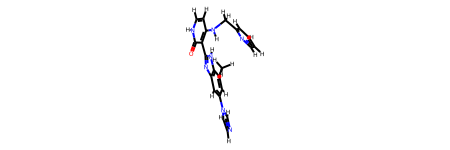

In [11]:
a_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'actives_dd.sdf')
d_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'decoys_dd.sdf')
l_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'crystal_ligand.mol2')
ic(a_path)

# decoys = fn.Mol2MolSupplier(d_path, sanitize=True)
dec = [m for m in Chem.SDMolSupplier(d_path, removeHs=False) if m]
ic(len(dec))
# Draw.MolsToGridImage(random.sample(decoys, 7), molsPerRow=7, subImgSize=(150,150), legends=[mol.GetProp('_Name') for mol in decoys[:7]],maxMols=100)

act = [m for m in Chem.SDMolSupplier(a_path, removeHs=False) if m]
ic(len(act))
# Draw.MolsToGridImage(random.sample(actives, 7), molsPerRow=7, subImgSize=(150,150), legends=[mol.GetProp('_Name') for mol in actives[:7]],maxMols=100)

lig = AllChem.MolFromMol2File(l_path, removeHs=False)
lig = Chem.AddHs(lig, addCoords=True)
lig

In [12]:
sim_dict = dict()
tim_dict = dict()

In [13]:
for mol in act:
    mol.SetProp('_Name', f'activesInChIKey{AllChem.MolToInchiKey(mol)}')
for mol in dec:
    mol.SetProp('_Name', f'InChIKey{AllChem.MolToInchiKey(mol)}')

### 2.3.1 mol2

In [14]:
prb_acpc_ml2_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'prb_acpc.mol2')
ref_acpc_ml2_path = l_path
out_acpc_ml2_path = os.path.join(base_path, 'demo-data/result/acpc', target_list[target_flag], f'{target_list[target_flag]}-ml2-result.txt')

fn.MolToSpecialFormatFile(act+dec, prb_acpc_ml2_path)

9434 molecules converted


In [24]:
sat = timeit.default_timer()
sim_dict['acpc-ml2'] = sm.acpc(ref_path=ref_acpc_ml2_path, prb_path=prb_acpc_ml2_path, out_path=out_acpc_ml2_path, num_core=n_jobs)
end = timeit.default_timer()
tim_dict['acpc-ml2'] = [len(act+dec)/(end-sat)]

2022-08-01 02:53:03.679 WARN : only scoring molecules, not removing duplicates
2022-08-01 02:53:03.680 INFO : 1 molecule(s) in /home/jovyan/work-home/molecule-3d-similarity/dude/all/igf1r/crystal_ligand.mol2
2022-08-01 02:53:05.849 INFO : speed: 4347.30 molecules/s


In [17]:
prb_acpc_ml2_bin_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'prb_acpc.mol2.bin')
out_acpc_ml2_bin_path = os.path.join(base_path, 'demo-data/result/acpc', target_list[target_flag], f'{target_list[target_flag]}-ml2-bin-result.txt')
os.system(f'acpc_codec -i {prb_acpc_ml2_path} -o {prb_acpc_ml2_bin_path}')

2022-08-01 02:42:03.618 INFO : molecules: 9434 reading speed: 6863.39 molecules/s


0

In [25]:
sat = timeit.default_timer()
sim_dict['acpc-ml2-bin'] = sm.acpc(ref_path=ref_acpc_ml2_path, prb_path=prb_acpc_ml2_bin_path, out_path=out_acpc_ml2_bin_path, num_core=n_jobs)
end = timeit.default_timer()
tim_dict['acpc-ml2-bin'] = [len(act+dec)/(end-sat)]

2022-08-01 02:53:06.726 WARN : only scoring molecules, not removing duplicates
2022-08-01 02:53:06.727 INFO : 1 molecule(s) in /home/jovyan/work-home/molecule-3d-similarity/dude/all/igf1r/crystal_ligand.mol2
2022-08-01 02:53:07.545 INFO : speed: 11529.22 molecules/s


### 2.3.2 pqr

In [21]:
prb_acpc_pqr_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'prb_acpc.pqr')
fn.MolToSpecialFormatFile(act+dec, prb_acpc_pqr_path)
ref_acpc_pqr_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'ref_acpc.pqr')
fn.MolToSpecialFormatFile([lig], ref_acpc_pqr_path)
out_acpc_pqr_path = os.path.join(base_path, 'demo-data/result/acpc', target_list[target_flag], f'{target_list[target_flag]}-pqr-result.txt')

9434 molecules converted
1 molecule converted


In [26]:
sat = timeit.default_timer()
sim_dict['acpc-pqr'] = sm.acpc(ref_path=ref_acpc_pqr_path, prb_path=prb_acpc_pqr_path, out_path=out_acpc_pqr_path, num_core=n_jobs)
end = timeit.default_timer()
tim_dict['acpc-pqr'] = [len(act+dec)/(end-sat)]

2022-08-01 02:53:09.285 WARN : only scoring molecules, not removing duplicates
2022-08-01 02:53:09.286 INFO : 1 molecule(s) in /home/jovyan/work-home/molecule-3d-similarity/dude/all/igf1r/ref_acpc.pqr
2022-08-01 02:53:11.240 INFO : speed: 4826.35 molecules/s


## 2.4 ESP-SIM

ic| a_path: '/home/jovyan/work-home/molecule-3d-similarity/dude/all/egfr/actives_dd.sdf'
ic| d_path: '/home/jovyan/work-home/molecule-3d-similarity/dude/all/egfr/decoys_dd.sdf'
ic| l_path: '/home/jovyan/work-home/molecule-3d-similarity/dude/all/egfr/crystal_ligand.mol2'
ic| len(dec): 35010
ic| len(act): 542


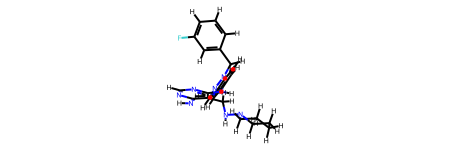

In [9]:
a_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'actives_dd.sdf')
d_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'decoys_dd.sdf')
l_path = os.path.join(base_path, dude_dir, target_list[target_flag], 'crystal_ligand.mol2')
ic(a_path)
ic(d_path)
ic(l_path)

# decoys = fn.Mol2MolSupplier(d_path, sanitize=True)
dec = [m for m in Chem.SDMolSupplier(d_path, removeHs=False) if m]
ic(len(dec))
# Draw.MolsToGridImage(random.sample(decoys, 7), molsPerRow=7, subImgSize=(150,150), legends=[mol.GetProp('_Name') for mol in decoys[:7]],maxMols=100)

act = [m for m in Chem.SDMolSupplier(a_path, removeHs=False) if m]
ic(len(act))
# Draw.MolsToGridImage(random.sample(actives, 7), molsPerRow=7, subImgSize=(150,150), legends=[mol.GetProp('_Name') for mol in actives[:7]],maxMols=100)

lig = AllChem.MolFromMol2File(l_path, removeHs=False)
lig = Chem.AddHs(lig, addCoords=True)
lig

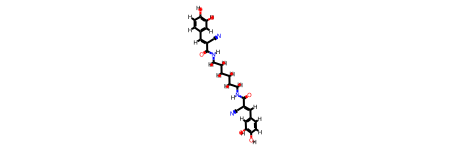

In [10]:
act[0]

In [11]:
len_a = len(act)
len_d = len(dec)

In [12]:
sim_dict = dict()
tim_dict = dict()

In [13]:
ali_o3a_time = 0
sta = timeit.default_timer()
act_o3a, align_score =al.rdkit_o3a(act, lig, n_jobs=n_jobs, verbose=1)
dec_o3a, align_score =al.rdkit_o3a(dec, lig, n_jobs=n_jobs, verbose=1)
end = timeit.default_timer()
ali_o3a_time = end - sta
ic(ali_o3a_time)

ali_cri_time = 0
sta = timeit.default_timer()
act_cri, align_score =al.rdkit_crippeno3a(act, lig, n_jobs=n_jobs, verbose=1)
dec_cri, align_score =al.rdkit_crippeno3a(dec, lig, n_jobs=n_jobs, verbose=1)
end = timeit.default_timer()
ali_cri_time = end - sta
ic(ali_cri_time)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 527 out of 542 | elapsed:    2.9s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 542 out of 542 | elapsed:    3.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 1200 tasks      | elapsed:    4.4s
[Parallel(n_jobs=8)]: Done 3200 tasks      | elapsed:   11.1s
[Parallel(n_jobs=8)]: Done 6000 tasks      | elapsed:   22.4s
[Parallel(n_jobs=8)]: Done 9600 tasks      | elapsed:   37.2s
[Parallel(n_jobs=8)]: Done 14000 tasks      | elapsed:   51.9s
[Parallel(n_jobs=8)]: Done 19200 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 25200 tasks      | elapsed:  1.5min
[Parallel(n_jobs=8)]: Done 32000 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 34995 out of 35010 | elapsed:  2.1min remaining:   

64.80594201525673

In [14]:
sat = timeit.default_timer()
act_sim_list = sm.esp_sim(act_cri, lig, n_jobs=n_jobs, verbose=1)
dec_sim_list = sm.esp_sim(dec_cri, lig, n_jobs=n_jobs, verbose=1)
end = timeit.default_timer()
sim_dict['esp-sim-crippeno3a-tanimoto-mmff-tanimoto'] = [(sim, 1) for sim in act_sim_list] + [(sim, 0) for sim in dec_sim_list]
tim_dict['esp-sim-crippeno3a-tanimoto-mmff-tanimoto'] = [(len_a + len_d) / (end - sat + ali_cri_time)]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  35 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 542 out of 542 | elapsed:    7.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 11248 tasks      | elapsed:    3.1s
[Parallel(n_jobs=8)]: Done 34680 tasks      | elapsed:    8.4s
[Parallel(n_jobs=8)]: Done 35010 out of 35010 | elapsed:    8.6s finished


In [15]:
sat = timeit.default_timer()
act_sim_list = sm.esp_sim(act_o3a, lig, n_jobs=n_jobs, verbose=1)
dec_sim_list = sm.esp_sim(dec_o3a, lig, n_jobs=n_jobs, verbose=1)
end = timeit.default_timer()
sim_dict['esp-sim-o3a-tanimoto-mmff-tanimoto'] = [(sim, 1) for sim in act_sim_list] + [(sim, 0) for sim in dec_sim_list]
tim_dict['esp-sim-o3a-tanimoto-mmff-tanimoto'] = [(len_a + len_d) / (end - sat + ali_o3a_time)]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 542 out of 542 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 11248 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 34554 tasks      | elapsed:    8.4s
[Parallel(n_jobs=8)]: Done 35010 out of 35010 | elapsed:    8.6s finished


In [16]:
sat = timeit.default_timer()
act_sim_list = sm.esp_sim(act_o3a, lig, shape_sim='protrude', n_jobs=n_jobs, verbose=1)
dec_sim_list = sm.esp_sim(dec_o3a, lig, shape_sim='protrude', n_jobs=n_jobs, verbose=1)
end = timeit.default_timer()
sim_dict['esp-sim-o3a-protrude-mmff-tanimoto'] = [(sim, 1) for sim in act_sim_list] + [(sim, 0) for sim in dec_sim_list]
tim_dict['esp-sim-o3a-protrude-mmff-tanimoto'] = [(len_a + len_d) / (end - sat + ali_o3a_time)]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 542 out of 542 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 11248 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 34680 tasks      | elapsed:    8.6s
[Parallel(n_jobs=8)]: Done 35010 out of 35010 | elapsed:    8.7s finished


In [17]:
sat = timeit.default_timer()
act_sim_list = sm.esp_sim(act_o3a, lig, shape_sim='tversky', n_jobs=n_jobs, verbose=1)
dec_sim_list = sm.esp_sim(dec_o3a, lig, shape_sim='tversky', n_jobs=n_jobs, verbose=1)
end = timeit.default_timer()
sim_dict['esp-sim-o3a-tversky-mmff-tanimoto'] = [(sim, 1) for sim in act_sim_list] + [(sim, 0) for sim in dec_sim_list]
tim_dict['esp-sim-o3a-tversky-mmff-tanimoto'] = [(len_a + len_d) / (end - sat + ali_o3a_time)]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 542 out of 542 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 11248 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 34428 tasks      | elapsed:    8.4s
[Parallel(n_jobs=8)]: Done 35010 out of 35010 | elapsed:    8.6s finished


In [18]:
sat = timeit.default_timer()
act_sim_list = sm.esp_sim(act_o3a, lig, systems='gasteiger', n_jobs=n_jobs, verbose=1)
dec_sim_list = sm.esp_sim(dec_o3a, lig, systems='gasteiger', n_jobs=n_jobs, verbose=1)
end = timeit.default_timer()
sim_dict['esp-sim-o3a-tanimoto-gasteiger-tanimoto'] = [(sim, 1) for sim in act_sim_list] + [(sim, 0) for sim in dec_sim_list]
tim_dict['esp-sim-o3a-tanimoto-gasteiger-tanimoto'] = [(len_a + len_d) / (end - sat + ali_o3a_time)]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 542 out of 542 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 6640 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 22640 tasks      | elapsed:    7.3s
[Parallel(n_jobs=8)]: Done 35010 out of 35010 | elapsed:   11.1s finished


In [19]:
sat = timeit.default_timer()
prb_charge = mlCharges(act+dec)
ref_charge = mlCharges([lig])[0]
end = timeit.default_timer()
ml_char_time = end - sat

In [ ]:
sat = timeit.default_timer()
act_sim_list = sm.esp_sim(act_o3a, lig, systems='ml', prb_charge=prb_charge[:len_a], ref_charge=ref_charge, n_jobs=n_jobs, verbose=1)
dec_sim_list = sm.esp_sim(dec_o3a, lig, systems='ml', prb_charge=prb_charge[len_a:], ref_charge=ref_charge, n_jobs=n_jobs, verbose=1)
end = timeit.default_timer()
sim_dict['esp-sim-o3a-tanimoto-ml-tanimoto'] = [(sim, 1) for sim in act_sim_list] + [(sim, 0) for sim in dec_sim_list]
tim_dict['esp-sim-o3a-tanimoto-ml-tanimoto'] = [(len_a + len_d) / (end - sat + ali_o3a_time + ml_char_time)]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 258 out of 258 | elapsed:    8.3s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 6640 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 14954 tasks      | elapsed:    4.8s
[Parallel(n_jobs=8)]: Done 14983 out of 14983 | elapsed:    4.9s finished


In [ ]:
sat = timeit.default_timer()
act_sim_list = sm.esp_sim(act_o3a, lig, metric='carbo', n_jobs=n_jobs, verbose=1)
dec_sim_list = sm.esp_sim(dec_o3a, lig, metric='carbo', n_jobs=n_jobs, verbose=1)
end = timeit.default_timer()
sim_dict['esp-sim-o3a-tanimoto-mmff-carbo'] = [(sim, 1) for sim in act_sim_list] + [(sim, 0) for sim in dec_sim_list]
tim_dict['esp-sim-o3a-tanimoto-mmff-carbo'] = [(len_a + len_d) / (end - sat + ali_o3a_time)]

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 258 out of 258 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 11248 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 14983 out of 14983 | elapsed:    3.7s finished


In [ ]:
sim_dict.keys()

dict_keys(['esp-sim-crippeno3a-tanimoto-mmff-tanimoto'])

In [ ]:
save_dir = os.path.join(base_path, f'demo-data/result/espsim/{target_list[target_flag]}/')
if not os.path.exists(save_dir):
    os.system(f"mkdir -p {save_dir}")

In [ ]:
with open(os.path.join(save_dir, f'{target_list[target_flag]}-sim_dict.pickle'), 'wb') as f:
    pickle.dump(sim_dict, f)
with open(os.path.join(save_dir, f'{target_list[target_flag]}-tim_dict.pickle'), 'wb') as f:
    pickle.dump(tim_dict, f)

In [ ]:
ic(save_dir)
with open(os.path.join(save_dir, f'{target_list[target_flag]}-sim_dict.pickle'), 'rb') as f:
    sim_dict = pickle.load(f)
with open(os.path.join(save_dir, f'{target_list[target_flag]}-tim_dict.pickle'), 'rb') as f:
    tim_dict = pickle.load(f)
sim_dict.keys()

ic| save_dir: '/home/jovyan/work-home/molecule-3d-similarity/demo-data/result/espsim/gcr/'


dict_keys(['esp-sim-crippeno3a-tanimoto-mmff-tanimoto', 'esp-sim-o3a-tanimoto-mmff-tanimoto', 'esp-sim-o3a-protrude-mmff-tanimoto', 'esp-sim-o3a-tversky-mmff-tanimoto', 'esp-sim-o3a-tanimoto-gasteiger-tanimoto', 'esp-sim-o3a-tanimoto-ml-tanimoto', 'esp-sim-o3a-tanimoto-mmff-carbo'])

## 2.3 评价指标

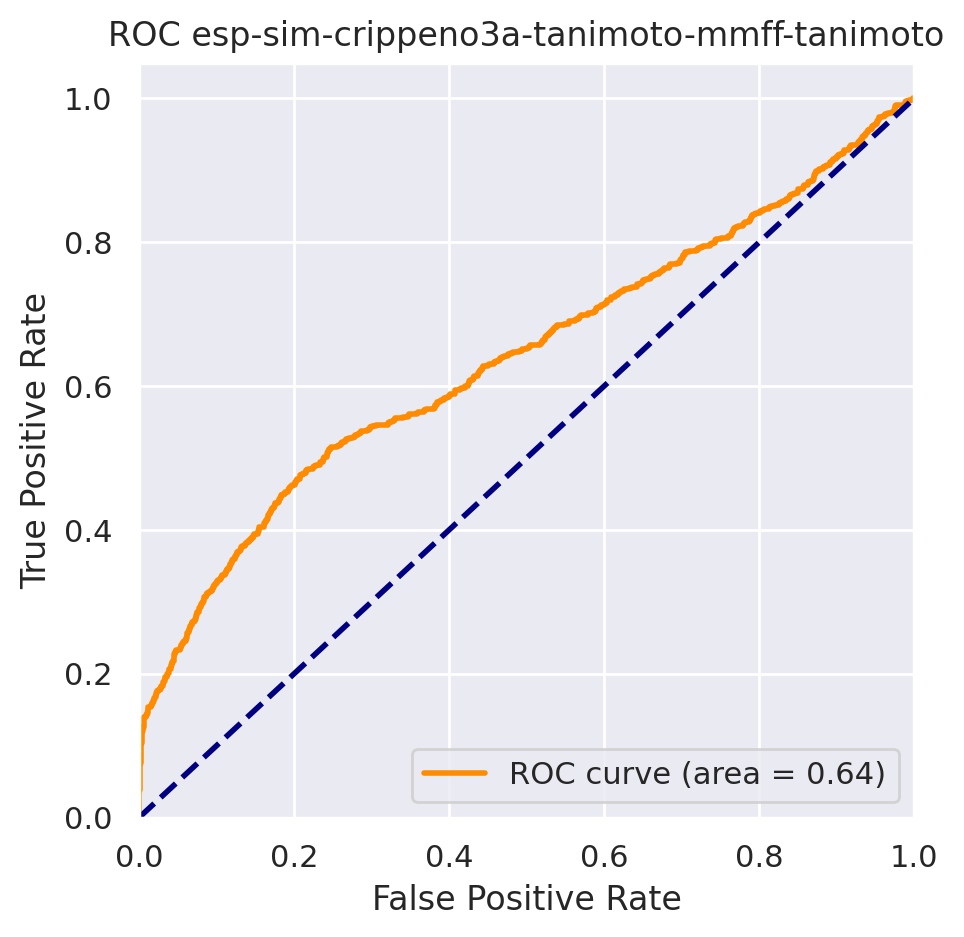

In [19]:
i = 1
for name, score in sim_dict.items():
    plt.figure(figsize=(5, 5), dpi=200)
    
    score_list = sorted(score, key=lambda x: x[0])

    y_lable = np.asarray([ele[1] for ele in score_list])
    y_score = np.asarray([ele[0] for ele in score_list])

    fpr, tpr, _ = metrics.roc_curve(y_lable, y_score)
    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=2,
        label="ROC curve (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC {name}")
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(save_dir, f'{i :0>2}-roc-{name}.png'))
    plt.show()
    i += 1

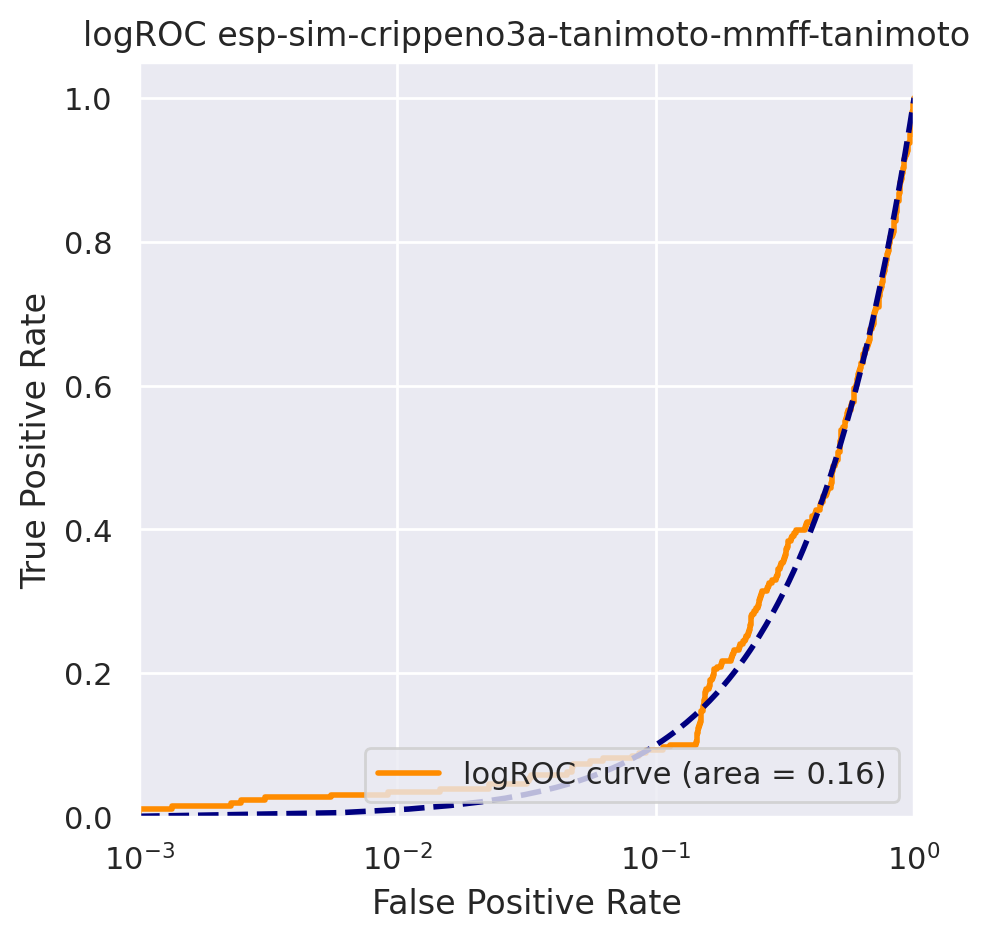

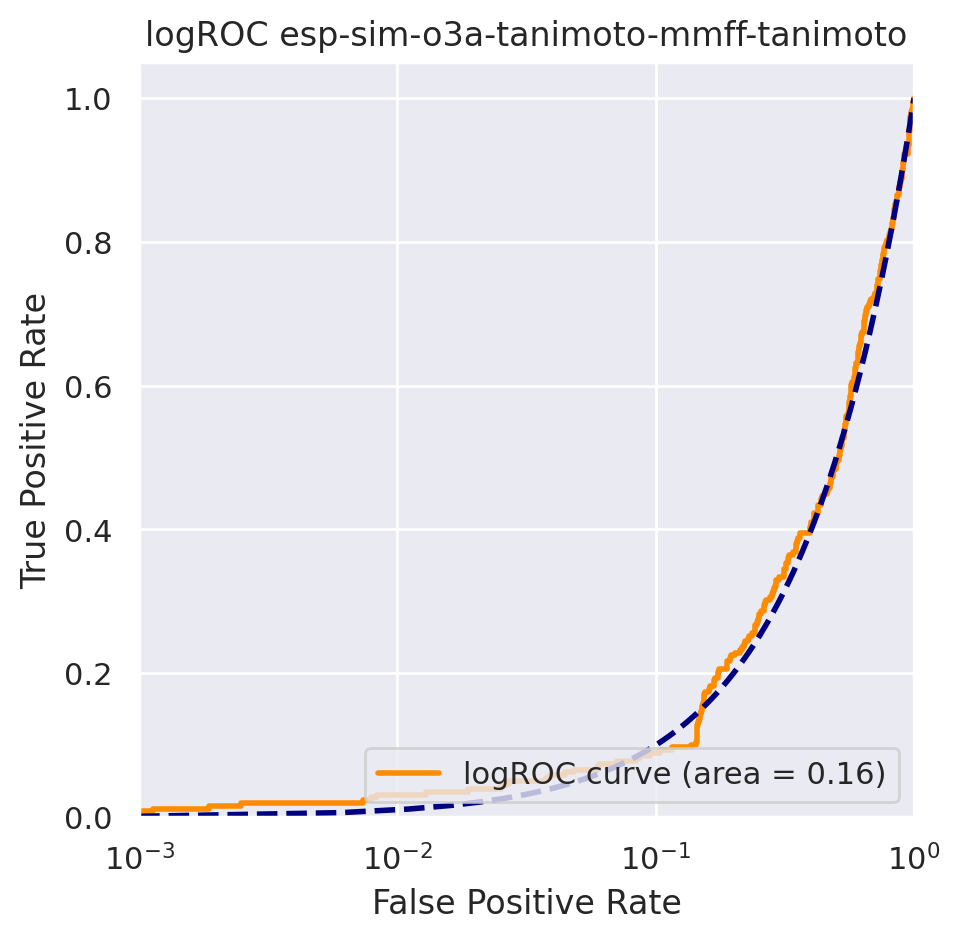

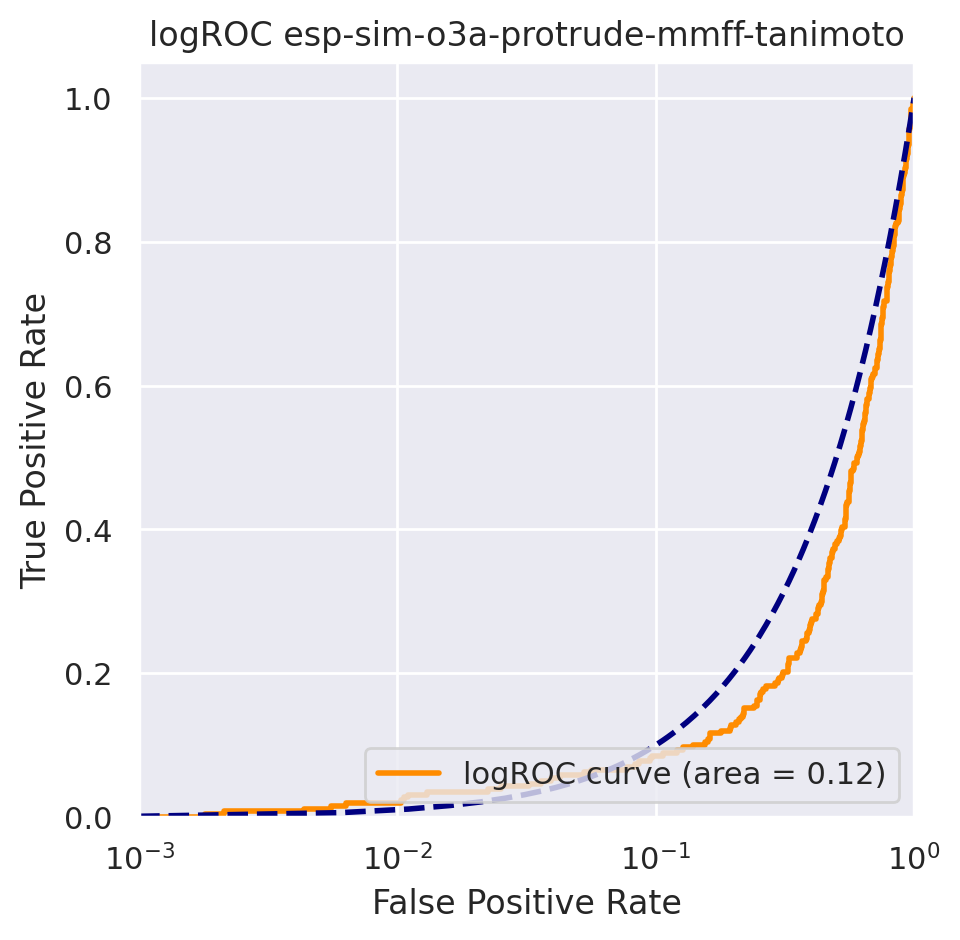

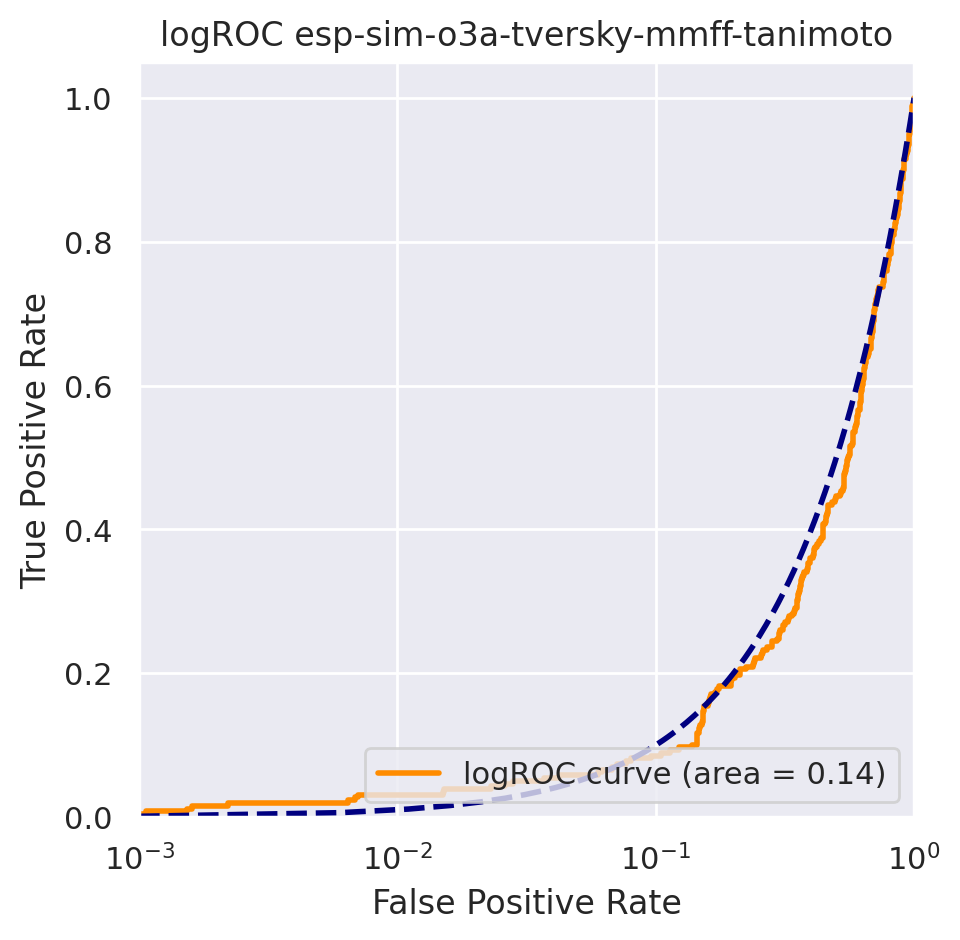

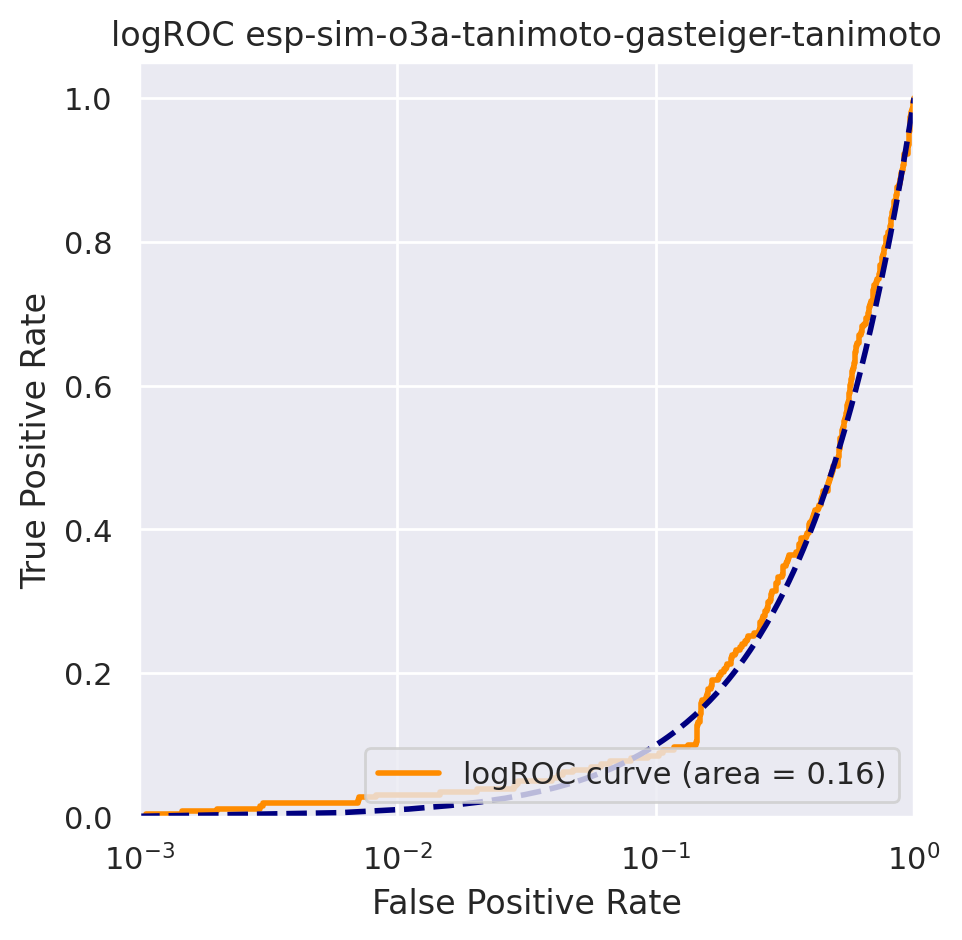

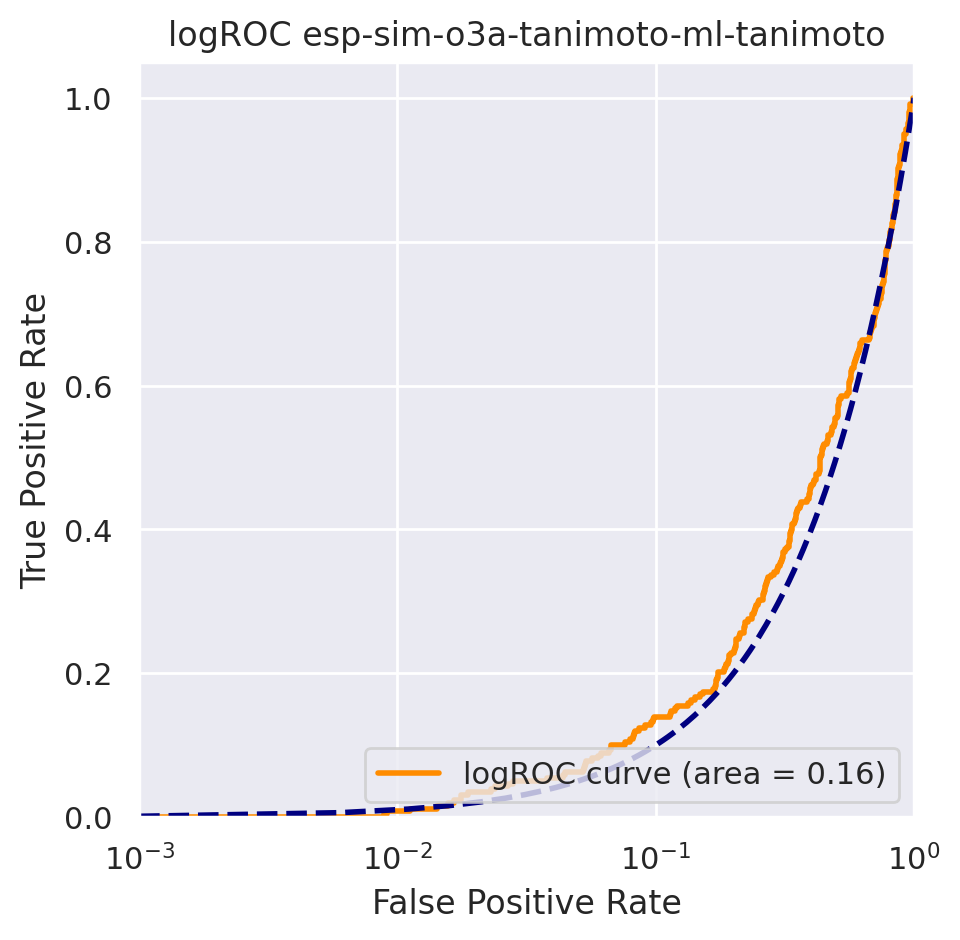

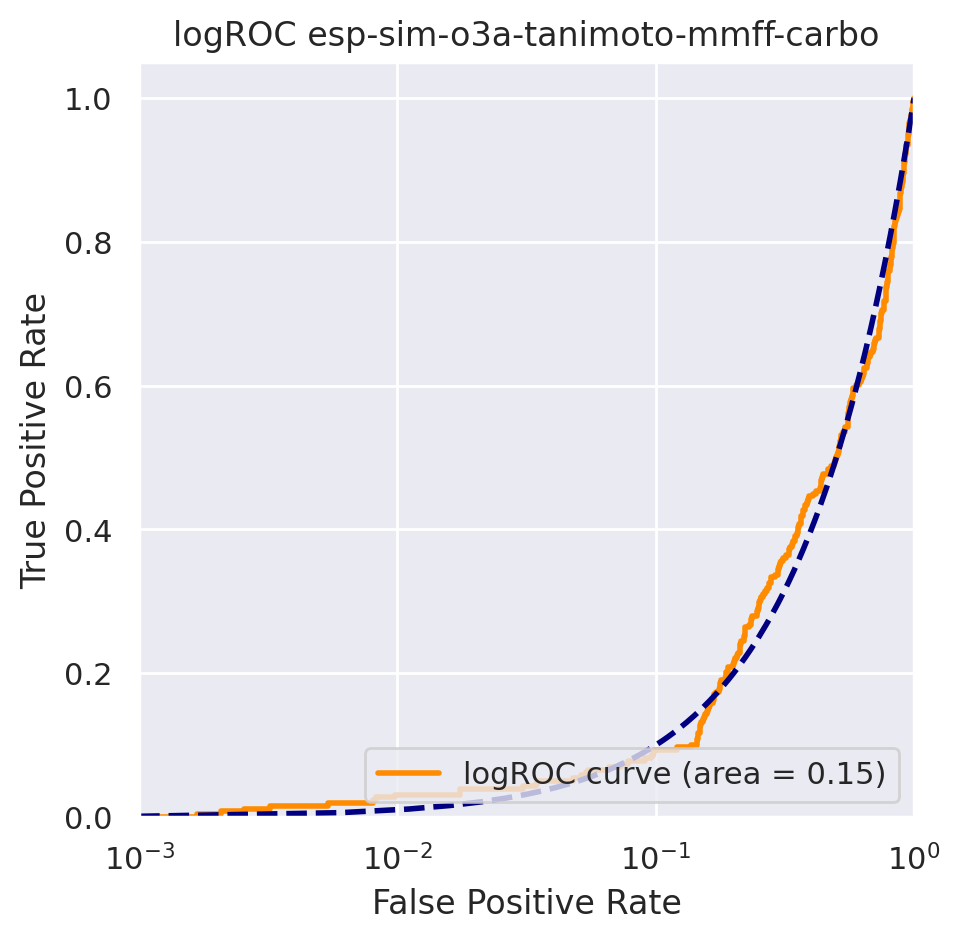

In [66]:
i = 1
for name, score in sim_dict.items():
    fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
    
    score_list = sorted(score, key=lambda x: x[0])

    y_lable = np.asarray([ele[1] for ele in score_list])
    y_score = np.asarray([ele[0] for ele in score_list])

    fpr, tpr, _ = metrics.roc_curve(y_lable, y_score)
    
    log_min = 0.001
    log_max = 1.0

    fpr = fpr.clip(log_min)
    idx = (fpr <= log_max)
    log_fpr = 1 - np.log10(fpr[idx]) / np.log10(log_min)
    
    log_roc_auc = metrics.auc(log_fpr, tpr[idx])


    plt.plot(
        fpr[idx],
        tpr[idx],
        color="darkorange",
        lw=2,
        label="logROC curve (area = %0.2f)" % log_roc_auc,
    )
    x = np.linspace(0.001, 1, 200)
    y = x
    plt.plot(x, y, color="navy", lw=2, linestyle="--")

    plt.ylim([0.0, 1.05])
    plt.xscale('log')
    plt.xlim([0.001, 1])
    ax.set_xticks([0.001, 0.01, 0.1, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"logROC {name}")
    plt.legend(loc="lower right")
    plt.savefig(os.path.join(save_dir, f'{i :0>2}-log_roc-{name}.png'))
    plt.show()
    i += 1

In [ ]:
x = np.linspace(0.001, 1, 200)
y = x
x = 1 - np.log10(x) / np.log10(log_min)
plt.plot(x, y, color="navy", lw=2, linestyle="--")
# plt.xscale('log')

In [ ]:
x = np.linspace(0.001, 1, 200)
y = x
plt.plot(x, y, color="navy", lw=2, linestyle="--")
plt.xscale('log')

In [ ]:
# np.asarray([1,3,4,5,6,7]).clip(4)
sorted([1,2,5,6,7], key=lambda x: -x)

In [67]:
result_list = []
for name, score in sim_dict.items():
    score_list = sorted(score, key=lambda x: -x[0])

    y_score = np.asarray([ele[0] for ele in score_list])
    y_lable = np.asarray([ele[1] for ele in score_list])
    
    metrics_list = mt.calculate_metrics(y_lable=y_lable, y_score=y_score)

    print(f'--- 🌟 {name} 🌟 ---')
    tmp_dict = {
        'name' : name,
        'time' : mean(tim_dict[name])
    }
    print(f'time: {mean(tim_dict[name])}')
    for m_name, m_value in metrics_list.items():
        tmp_dict[m_name] = m_value
        print(f'{m_name:<30}: {m_value}')
    result_list.append(tmp_dict)

--- 🌟 esp-sim-crippeno3a-tanimoto-mmff-tanimoto 🌟 ---
time: 370.1360926780274
auc                           : 0.5066566397990073
log_acu                       : 0.1600211667067507
adjusted_log_auc              : 0.0154211667067507
EF^0.5%                       : 5.3703312191684285
EF^1%                         : 3.474920200638395
EF^2%                         : 1.9368407675689414
EF^5%                         : 1.4710343706503297
EF^8%                         : 1.0168414029736943
EF^10%                        : 0.9296835684330919
HR^1%                         : 0.058823529411764705
HR^5%                         : 0.07364341085271318
HR^10%                        : 0.09302325581395349
BEDROC(alpha=20.0)            : 0.07601698957792961
BEDROC(alpha=80.5)            : 0.057715418342698194
BEDROC(alpha=321.9)           : 0.09454016072946805
ER_1%                         : 2.3865880853775088
--- 🌟 esp-sim-o3a-tanimoto-mmff-tanimoto 🌟 ---
time: 241.52997663713438
auc                        

In [68]:
pd.DataFrame(result_list).to_excel(os.path.join(save_dir, f'{target_list[target_flag]}_results.xlsx'))

In [ ]:
molcalx = '/home/jovyan/work-home/molecule-3d-similarity/pde5_score.csv'
df = pd.read_csv(molcalx)
df_sorted = df.sort_values(by=['score'],ascending=True)
score = df_sorted['score']
x = np.array(score)*(-1)
y = df_sorted['label']
label_map = {'active': 1, 'decoy': 0}
labels = [label_map[y_true] for y_true in y]
y = np.array(labels)

In [ ]:
auc = m.roc_auc(y, x, pos_label=1, ascending_score=False)
print("ROC AUC = ",auc)
bedroc = m.bedroc(y, x, alpha=20.0, pos_label=1)
print("alpha=20.0 BEDROC = ",bedroc)
logauc = m.roc_log_auc(y, x, pos_label=1, ascending_score=False, log_min=0.001, log_max=1.0)
print("logAUC [0.1%,100%]  = ",logauc)

In [ ]:
result_string = 'ROCSComboscore 0.598 ± 0.152 0.681 ± 0.166 0.674 ± 0.115 0.727 ± 0.128 ROCSColorscore 0.620 ± 0.139 0.712 ± 0.159 0.677 ± 0.117 0.752 ± 0.136 ROCSShapeTanimoto 0.547 ± 0.138 0.611 ± 0.163 0.618 ± 0.105 0.667 ± 0.127 Phase Shape_Mmod 0.677 ± 0.143 0.686 ± 0.145 0.772 ± 0.105 0.769 ± 0.108 Phase Shape_Ele 0.674 ± 0.153 0.688 ± 0.158 0.753 ± 0.105 0.750 ± 0.111 Phase Shape_Pharm 0.692 ± 0.160 0.694 ± 0.168 0.761 ± 0.145 0.767 ± 0.143 Shape-it 0.541 ± 0.133 0.590 ± 0.141 0.612 ± 0.110 0.639 ± 0.115 Align-it 0.659 ± 0.137 0.680 ± 0.157 0.729 ± 0.132 0.746 ± 0.139 ShaEPbest 0.658 ± 0.122 0.660 ± 0.139 0.709 ± 0.099 0.699 ± 0.120 ShaEPshape 0.625 ± 0.139 0.632 ± 0.143 0.681 ± 0.105 0.676 ± 0.116 ShaEPESP 0.606 ± 0.109 0.591 ± 0.117 0.627 ± 0.105 0.585 ± 0.125 SHAFTS 0.733 ± 0.144 0.731 ± 0.157 0.792 ± 0.129 0.782 ± 0.135 WEGA 0.645 ± 0.143 0.659 ± 0.154 0.716 ± 0.107 0.716 ± 0.125 LIGSIFT 0.718 ± 0.133 0.755 ± 0.143 0.758 ± 0.117 0.784 ± 0.120 LS-align 0.699 ± 0.126 0.759 ± 0.119 0.773 ± 0.098 0.786 ± 0.096'

In [ ]:
result_string.split(' ')[13]

In [ ]:
result_string.split(' ')[14]

In [ ]:
cry_single = [0.598, 0.620, ]

In [ ]:
pccs = np.corrcoef(x, y)

## 2.4 可视化

In [ ]:
seed_ligands = {
    'pde5a': [
        'CCCc1nn(c2c1nc([nH]c2=O)c1cc(ccc1OCC)S(=O)(=O)n1ccn(cc1)C)C',
        'CCCc1nn(c2c1nc([nH]c2=O)c1cc(ccc1OCC)S(=O)(=O)N1CCN(CC1)Cc1ccc2c(c1)OCO2)C',
    ],
    'akt1': [
        'Clc1c[nH]c2c1c(ncn2)N1CCc2c(C1)[nH]cn2',
        '[NH3+]C(Cc1c[nH]c2c1cccc2)COc1cncc(c1)c1ccc2c(c1)C(C(=O)N2)C(Cc1ccccn1)(C)C'
    ],
    'ada': [
        'CC(C(n1cnc(c1)C(=O)N)CCc1cccc2c1cccc2)O',
        'CC(C(n1cnc2c1ccnc2N)CCCCCC)O'
    ],
    'andr': [
        'OC1CCC2(C(=C1)CCC1C2CCC2(C1CCC2O)C)C',
        'N#Cc1ccc(cc1C(F)(F)F)N1C(=O)C2C(C1=O)C1(OC2(C)CN(C1)c1cccc(c1)C(=O)N)C'
    ],
    'def': [
        'CCCCCC(C(=O)NC(C(=O)N1CCCC1CO)C(C)C)CC(=O)NO',
        'O=CN(CC(C(=O)NC(C(C)(C)C)C(=O)c1ccc(cc1)F)CC1CCCC1)O'
    ],
    'gria2': [
        'O=c1[nH]c2cc(c(cc2n(c1=O)CP(=O)(O)O)N1CCOCC1)C(F)(F)F',
        '[O-][N+](=O)c1cc2[nH]c(=O)c(nc2cc1n1ccc(c1)C(=O)[O-])[O-]',
    ]
}

In [ ]:
cry_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(seed_ligands[target_list[target_flag]][0]))
clu_smiles = Chem.MolToSmiles(Chem.MolFromSmiles(seed_ligands[target_list[target_flag]][1]))
cry_inchi = Chem.MolToInchiKey(Chem.MolFromSmiles(cry_smiles))
clu_inchi = Chem.MolToInchiKey(Chem.MolFromSmiles(clu_smiles))

cry_mol = Chem.MolFromSmiles(cry_smiles)
cry_mol = AllChem.AddHs(cry_mol, addCoords=True)
clu_mol = Chem.MolFromSmiles(clu_smiles)
clu_mol = AllChem.AddHs(clu_mol, addCoords=True)

In [ ]:
for m in actives:
    tmp_smiles = Chem.MolToSmiles(m)
    tmp_inchi = Chem.MolToInchiKey(m)

    if cry_smiles == tmp_smiles:
        print('cry find')
    
    if clu_inchi == tmp_inchi:
        print('clu find')   

In [ ]:
fp_list = []
for m in actives:
    fp_list.append(np.asarray(AllChem.GetMorganFingerprintAsBitVect(m,2,useFeatures=True)))
fp_list.append(np.asarray(AllChem.GetMorganFingerprintAsBitVect(ligand,2,useFeatures=True)))
fp_list.append(np.asarray(AllChem.GetMorganFingerprintAsBitVect(cry_mol,2,useFeatures=True)))
fp_list.append(np.asarray(AllChem.GetMorganFingerprintAsBitVect(clu_mol,2,useFeatures=True)))

tsne = TSNE(n_components=2, random_state=2022)
z = tsne.fit_transform(fp_list)



In [ ]:
plt.figure(figsize=(5, 5), dpi=200)
plt.scatter(z[:-2, 0], z[:-2, 1])
plt.scatter(z[-3][0], z[-3][1])
# plt.scatter(z[-2][0], z[-2][1], color='beige')
# plt.scatter(z[67][0], z[67][1], color='beige')
# plt.scatter(z[-1][0], z[-1][1], color='springgreen')
# plt.scatter(z[285][0], z[285][1], color='springgreen')
# plt.scatter(z[215][0], z[215][1], color='lightcyan')
plt.scatter(z[291][0], z[291][1], color='lightcyan')
# plt.scatter(z[259][0], z[259][1], color='lightskyblue')
# plt.scatter(z[119][0], z[119][1], color='lightskyblue')
# plt.scatter(z[26][0], z[26][1], color='lightcoral')
# plt.scatter(z[46][0], z[46][1], color='lightcoral')
# seed = random.sample(list(range(len(actives))), 1)
# ic(seed)
# plt.scatter(z[seed[0]][0], z[seed[0]][1], color='beige')

In [ ]:
from rdkit.DataStructs import TanimotoSimilarity, TverskySimilarity
fp1 = AllChem.GetMorganFingerprintAsBitVect(actives[-97],2,useFeatures=True)
fp2 = AllChem.GetMorganFingerprintAsBitVect(ligand,2,useFeatures=True)
TanimotoSimilarity(fp1, fp2)

In [ ]:
# 285
# -1

# 67
# -2

# 215
# 291

# 259
# 119

# 26
# 46

In [ ]:
len(actives)

In [ ]:
actives[26].RemoveAllConformers()
actives[26]

In [ ]:
actives[-12].RemoveAllConformers()
actives[-12]

In [ ]:
actives[-15].RemoveAllConformers()
actives[-15]

In [ ]:
actives[-97].RemoveAllConformers()
actives[-97]

In [ ]:
actives[-99].RemoveAllConformers()
actives[-99]

In [ ]:
actives[-5].RemoveAllConformers()
actives[-5]

In [ ]:
clu_mol

In [ ]:
cry_mol

In [ ]:
ligand.RemoveAllConformers()
ligand

In [ ]:
actives[-8].RemoveAllConformers()
actives[-8]

In [ ]:
fp_list = []
for m in actives:
    fp_list.append(np.asarray(AllChem.GetMorganFingerprintAsBitVect(m,2)))
fp_list.append(np.asarray(AllChem.GetMorganFingerprintAsBitVect(ligand,2)))
fp_list.append(np.asarray(AllChem.GetMorganFingerprintAsBitVect(cry_mol,2)))
fp_list.append(np.asarray(AllChem.GetMorganFingerprintAsBitVect(clu_mol,2)))

tsne = TSNE(n_components=2, random_state=2022)
z = tsne.fit_transform(fp_list)

plt.figure(figsize=(5, 5), dpi=200)
plt.scatter(z[:-2, 0], z[:-2, 1])
plt.scatter(z[-3][0], z[-3][1])
plt.scatter(z[-2][0], z[-2][1])
plt.scatter(z[-1][0], z[-1][1])

In [ ]:
fp_list = []
for m in actives:
    fp_list.append(np.asarray(AllChem.GetMorganFingerprintAsBitVect(m,2,useFeatures=True)))
fp_list.append(np.asarray(AllChem.GetMorganFingerprintAsBitVect(ligand,2,useFeatures=True)))
fp_list.append(np.asarray(AllChem.GetMorganFingerprintAsBitVect(cry_mol,2,useFeatures=True)))
fp_list.append(np.asarray(AllChem.GetMorganFingerprintAsBitVect(clu_mol,2,useFeatures=True)))

tsne = PCA(n_components=2, random_state=2022)
z = tsne.fit_transform(fp_list)

plt.figure(figsize=(5, 5), dpi=200)
plt.scatter(z[:-2, 0], z[:-2, 1])
plt.scatter(z[-3][0], z[-3][1])
plt.scatter(z[-2][0], z[-2][1])
plt.scatter(z[-1][0], z[-1][1])

In [ ]:
fp_list = []
for m in actives:
    fp_list.append(np.asarray(AllChem.GetMorganFingerprintAsBitVect(m,2)))
fp_list.append(np.asarray(AllChem.GetMorganFingerprintAsBitVect(ligand,2)))
fp_list.append(np.asarray(AllChem.GetMorganFingerprintAsBitVect(cry_mol,2)))
fp_list.append(np.asarray(AllChem.GetMorganFingerprintAsBitVect(clu_mol,2)))

tsne = PCA(n_components=2, random_state=2022)
z = tsne.fit_transform(fp_list)

plt.figure(figsize=(5, 5), dpi=200)
plt.scatter(z[:-2, 0], z[:-2, 1])
plt.scatter(z[-3][0], z[-3][1])
plt.scatter(z[-2][0], z[-2][1])
plt.scatter(z[-1][0], z[-1][1])

In [6]:
from rdkit import Chem
from rdkit.Chem import AllChem

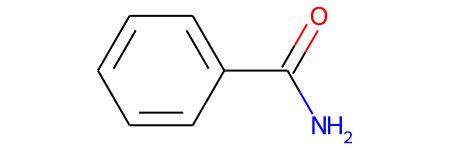

In [33]:
mol = Chem.MolFromSmiles('c1ccccc(C(N)=O)1')
mol

In [34]:
for atm in mol.GetAtoms():
    ic(dir(atm))
    ic(atm.GetAtomicNum())
    break

ic| dir(atm): ['ClearProp',
               'DescribeQuery',
               'GetAtomMapNum',
               'GetAtomicNum',
               'GetBonds',
               'GetBoolProp',
               'GetChiralTag',
               'GetDegree',
               'GetDoubleProp',
               'GetExplicitBitVectProp',
               'GetExplicitValence',
               'GetFormalCharge',
               'GetHybridization',
               'GetIdx',
               'GetImplicitValence',
               'GetIntProp',
               'GetIsAromatic',
               'GetIsotope',
               'GetMass',
               'GetMonomerInfo',
               'GetNeighbors',
               'GetNoImplicit',
               'GetNumExplicitHs',
               'GetNumImplicitHs',
               'GetNumRadicalElectrons',
               'GetOwningMol',
               'GetPDBResidueInfo',
               'GetProp',
               'GetPropNames',
               'GetPropsAsDict',
               'GetQueryType',
         

In [35]:
Chem.GetAdjacencyMatrix(mol)[0]

array([0, 1, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

In [36]:
[a.GetAtomicNum() for a in mol.GetAtoms()]

[6, 6, 6, 6, 6, 6, 6, 7, 8]

In [44]:
[a.GetBonds() for a in mol.GetAtoms()][6][].GetBondType()

rdkit.Chem.rdchem.BondType.DOUBLE

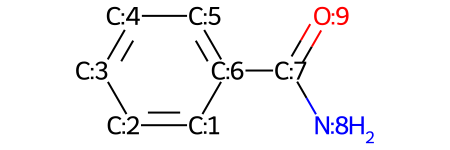

In [38]:
# Create an rdkit mol object
# Iterate over the atoms
for i, atom in enumerate(mol.GetAtoms()):
    # For each atom, set the property "molAtomMapNumber" to a custom number, let's say, the index of the atom in the molecule
    atom.SetProp("molAtomMapNumber", str(atom.GetIdx()+1))

mol

In [15]:
tmp_list = []
for root, dirs, files in os.walk(os.path.join(base_path, dude_dir), topdown=False):
    tmp_dict = {'act_ism': None, 'dec_ism': None}
    for name in files:
        if   'actives_final.ism' in name:
            tmp_dict['act_ism'] = os.path.join(root, name)
        elif 'decoys_final.ism' in name:
            tmp_dict['dec_ism'] = os.path.join(root, name)
    tmp_list.append(tmp_dict)

In [16]:
ism_path_df = pd.DataFrame(tmp_list).dropna()

In [29]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [71]:
def extract_info_from_smiles(series: pd.Series):
    print(f"🌟  {series.name+1}-{series['act_ism'].split('/')[-2]}  🌟")
    act = pd.read_csv(series['act_ism'], sep=' ',  header=None, names=['smiles', '-', 'chemblid'])
    dec = pd.read_csv(series['dec_ism'], sep=' ',  header=None, names=['smiles', '-', 'chemblid'])

    def get_charges(series: pd.Series):
        mol = AllChem.MolFromSmiles(series['smiles'])
        if not mol:
            return []
        return [a.GetAtomicNum() for a in mol.GetAtoms()]
    
    ic(act.head(5))
    tqdm.pandas()
    act['charges'] = act.progress_apply(get_charges, axis=1)
    dec['charges'] = dec.progress_apply(get_charges, axis=1)

    return [dict(Counter([cha for ele in act['charges'].tolist() for cha in ele if ele])), dict(Counter([cha for ele in dec['charges'].tolist() for cha in ele if ele]))]

In [72]:
extract_info_from_smiles(ism_path_df.iloc[0])

ic| act.head(5):                                               smiles       -       chemblid
                 0                  C#CCOc3nc(c1ccccc1)nc4sc2CCCc2c34  630004  CHEMBL1087078
                 1  OC[C@H]3OC(n1cnc2c(NCCS(O)(=O)=O)ncnc12)[C@H](...  607385   CHEMBL610435
                 2  CCNC(=O)[C@H]4OC(n2cnc3c(N)nc(C#Cc1ccc(CCC(O)=...  605505   CHEMBL605065
                 3         Ic5cccc(n1c(=S)sc3c1ncn4nc(c2ccco2)nc34)c5  623098  CHEMBL1093479
                 4                C=CCn1c(=S)sc3c1ncn4nc(c2ccco2)nc34  623027  CHEMBL1092271


🌟  1-aa2ar  🌟


100%|██████████| 31550/31550 [00:13<00:00, 2331.89it/s]


[{6: 9627, 8: 1151, 7: 2930, 16: 108, 53: 2, 17: 34, 9: 75, 35: 16},
 {6: 609048,
  8: 118095,
  7: 126634,
  16: 16445,
  17: 5797,
  9: 6305,
  35: 1549,
  15: 129,
  1: 94,
  53: 62}]

In [68]:
out = Parallel(n_jobs=n_jobs, verbose=1)(delayed(extract_info_from_smiles)(row) for _, row in ism_path_df.iterrows()) 

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


🌟  aa2ar  🌟
🌟  abl1  🌟
🌟  ace  🌟
🌟  aces  🌟
🌟  ada  🌟
🌟  ada17  🌟
🌟  adrb1  🌟
🌟  adrb2  🌟


ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
  0%|          | 0/10750 [00:00<?, ?it/s]ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
  0%|          | 0/16450 [00:00<?, ?it/s]

🌟  akt1  🌟


 43%|████▎     | 7131/16450 [00:02<00:03, 2855.61it/s]]

🌟  akt2  🌟


100%|█████████▉| 16844/16900 [00:05<00:00, 3073.11it/s]

🌟  aldr  🌟


 69%|██████▉   | 11327/16450 [00:03<00:01, 2994.51it/s]

🌟  ampc  🌟
🌟  andr  🌟


  0%|          | 0/122 [00:00<?, ?it/s]

🌟  aofb  🌟
🌟  bace1  🌟


 10%|█         | 1848/18100 [00:00<00:05, 2714.19it/s]]

🌟  braf  🌟


 90%|████████▉ | 23564/26250 [00:08<00:00, 3011.45it/s]

🌟  cah2  🌟


 63%|██████▎   | 9003/14350 [00:02<00:01, 3272.56it/s]]

🌟  casp3  🌟


 85%|████████▍ | 26749/31550 [00:09<00:01, 2862.09it/s]

🌟  cdk2  🌟


 76%|███████▌  | 7522/9950 [00:02<00:00, 2694.18it/s]]]

🌟  comt  🌟


 27%|██▋       | 8350/31172 [00:02<00:06, 3347.10it/s]]

🌟  cp2c9  🌟


100%|██████████| 3850/3850 [00:01<00:00, 3522.39it/s]]]
ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
 69%|██████▊   | 12427/18100 [00:04<00:02, 2609.17it/s]

🌟  cp3a4  🌟
🌟  csf1r  🌟


 33%|███▎      | 9232/27850 [00:02<00:06, 3077.66it/s]]

🌟  cxcr4  🌟


100%|██████████| 7450/7450 [00:02<00:00, 2909.46it/s]


🌟  def  🌟
🌟  dhi1  🌟
🌟  dpp4  🌟
🌟  drd3  🌟


  0%|          | 0/231 [00:00<?, ?it/s]

🌟  dyr  🌟


 75%|███████▍  | 23270/31172 [00:07<00:02, 3109.36it/s]

🌟  egfr  🌟
🌟  esr1  🌟


 58%|█████▊    | 10010/17200 [00:03<00:02, 3274.81it/s]

🌟  esr2  🌟
🌟  fa10  🌟


 55%|█████▌    | 11409/20685 [00:04<00:03, 2600.58it/s]

🌟  fa7  🌟


 39%|███▊      | 2418/6250 [00:00<00:01, 2737.02it/s]s]

🌟  fabp4  🌟


 84%|████████▍ | 5263/6250 [00:01<00:00, 2681.44it/s]s]

🌟  fak1  🌟


 27%|██▋       | 1444/5350 [00:00<00:01, 2841.40it/s]s]

🌟  fgfr1  🌟


 82%|████████▏ | 4362/5350 [00:01<00:00, 2832.75it/s]s]

🌟  fkb1a  🌟


 75%|███████▌  | 15181/20199 [00:05<00:01, 3033.30it/s]

🌟  fnta  🌟


  6%|▋         | 3253/51500 [00:01<00:17, 2696.66it/s]]

🌟  fpps  🌟
🌟  gcr  🌟
🌟  glcm  🌟


ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?
 74%|███████▍  | 25975/35050 [00:09<00:03, 2659.93it/s][08:35:41] Explicit valence for atom # 7 N, 5, is greater than permitted


🌟  gria2  🌟


 24%|██▍       | 3647/15000 [00:01<00:04, 2616.26it/s]]

🌟  grik1  🌟
🌟  hdac2  🌟


 19%|█▉        | 9883/51500 [00:03<00:16, 2518.89it/s]]

🌟  hdac8  🌟


100%|██████████| 6550/6550 [00:01<00:00, 3335.14it/s]s]


🌟  hivint  🌟


100%|██████████| 35050/35050 [00:13<00:00, 2676.35it/s]
[08:35:45] Explicit valence for atom # 9 N, 5, is greater than permitted
 98%|█████████▊| 27866/28325 [00:10<00:00, 2687.84it/s]

🌟  hivpr  🌟


 73%|███████▎  | 10912/15000 [00:03<00:01, 2745.81it/s]

🌟  hivrt  🌟
🌟  hmdh  🌟


 33%|███▎      | 17224/51500 [00:06<00:12, 2702.39it/s]

🌟  hs90a  🌟


 36%|███▌      | 18314/51500 [00:06<00:13, 2544.76it/s]

🌟  hxk4  🌟
🌟  igf1r  🌟


  0%|          | 0/43 [00:00<?, ?it/s]

🌟  inha  🌟


 42%|████▏     | 21480/51500 [00:08<00:11, 2541.43it/s]

🌟  ital  🌟


 34%|███▍      | 3190/9300 [00:01<00:02, 2574.84it/s]

🌟  jak2  🌟
🌟  kif11  🌟


 30%|██▉       | 10579/35750 [00:03<00:08, 2996.13it/s]

🌟  kit  🌟


  0%|          | 0/57 [00:00<?, ?it/s]

🌟  kith  🌟
🌟  kpcb  🌟


  7%|▋         | 575/8700 [00:00<00:02, 2886.79it/s]

🌟  lck  🌟


 13%|█▎        | 1171/8700 [00:00<00:02, 2848.20it/s]s]

🌟  lkha4  🌟
🌟  mapk2  🌟


 61%|██████    | 31198/51500 [00:11<00:08, 2486.87it/s]

🌟  mcr  🌟


 59%|█████▉    | 5133/8700 [00:01<00:01, 2827.50it/s]s]

🌟  met  🌟


  0%|          | 0/79 [00:00<?, ?it/s]

🌟  mk01  🌟


  0%|          | 0/104 [00:00<?, ?it/s]

🌟  mk10  🌟


 26%|██▋       | 7252/27400 [00:02<00:08, 2357.50it/s]

🌟  mk14  🌟


100%|██████████| 9450/9450 [00:03<00:00, 2940.43it/s]]]


🌟  mmp13  🌟


 53%|█████▎    | 5914/11250 [00:02<00:01, 2827.91it/s]]

🌟  mp2k1  🌟


 35%|███▌      | 2887/8150 [00:00<00:01, 2708.11it/s]s]

🌟  nos1  🌟


 72%|███████▏  | 5881/8150 [00:02<00:00, 2910.33it/s]s]

🌟  nram  🌟


 30%|███       | 10775/35850 [00:03<00:09, 2772.71it/s]

🌟  pa2ga  🌟


 32%|███▏      | 11341/35850 [00:04<00:08, 2791.60it/s]

🌟  parp1  🌟
🌟  pde5a  🌟


 37%|███▋      | 13212/35850 [00:04<00:07, 2861.02it/s]

🌟  pgh1  🌟


  8%|▊         | 2304/30050 [00:00<00:08, 3228.38it/s]]

🌟  pgh2  🌟


  0%|          | 0/107 [00:00<?, ?it/s]

🌟  plk1  🌟


 27%|██▋       | 7511/27550 [00:02<00:07, 2665.21it/s]ic| Error: Failed to access the underlying source code for analysis. Was ic() invoked in a REPL (e.g. from the command line), a frozen application (e.g. packaged with PyInstaller), or did the underlying source code change during execution?


🌟  pnph  🌟


 36%|███▌      | 9812/27550 [00:03<00:06, 2833.34it/s]

🌟  ppara  🌟
🌟  ppard  🌟


 51%|█████▏    | 15461/30050 [00:04<00:04, 3447.17it/s]

🌟  pparg  🌟


 91%|█████████▏| 27493/30050 [00:08<00:00, 3307.01it/s]

🌟  prgr  🌟
🌟  ptn1  🌟
🌟  pur2  🌟


 78%|███████▊  | 15188/19399 [00:05<00:01, 2772.63it/s]

🌟  pygm  🌟
🌟  pyrd  🌟


 81%|████████  | 15757/19399 [00:05<00:01, 2802.46it/s]

🌟  reni  🌟


  5%|▌         | 324/6300 [00:00<00:01, 3239.53it/s]/s]

🌟  rock1  🌟


 66%|██████▌   | 16626/25300 [00:06<00:03, 2725.46it/s]

🌟  rxra  🌟


 48%|████▊     | 3025/6300 [00:00<00:00, 3289.25it/s]

🌟  sahh  🌟
🌟  src  🌟


  3%|▎         | 891/34500 [00:00<00:12, 2798.72it/s]s]

🌟  tgfr1  🌟


  0%|          | 0/7450 [00:00<?, ?it/s]

🌟  thb  🌟
🌟  thrb  🌟


 57%|█████▋    | 265/461 [00:00<00:00, 2649.53it/s]

🌟  try1  🌟


  0%|          | 0/7650 [00:00<?, ?it/s]

🌟  tryb1  🌟
🌟  tysy  🌟


  4%|▎         | 346/9850 [00:00<00:02, 3458.15it/s]s]

🌟  urok  🌟


 23%|██▎       | 6338/27004 [00:02<00:06, 2960.71it/s]

🌟  vgfr2  🌟


 27%|██▋       | 6943/25980 [00:02<00:06, 2807.10it/s]

🌟  wee1  🌟


 34%|███▍      | 9159/27004 [00:03<00:06, 2760.42it/s]

🌟  xiap  🌟


100%|██████████| 34500/34500 [00:12<00:00, 2735.14it/s]
[Parallel(n_jobs=8)]: Done 102 out of 102 | elapsed:  1.1min finished


In [73]:
out

[[{6: 9627, 8: 1151, 7: 2930, 16: 108, 53: 2, 17: 34, 9: 75, 35: 16},
  {6: 609048,
   8: 118095,
   7: 126634,
   16: 16445,
   17: 5797,
   9: 6305,
   35: 1549,
   15: 129,
   1: 94,
   53: 62}],
 [{6: 4409, 8: 307, 17: 73, 7: 980, 16: 40, 9: 166, 15: 12, 35: 3, 53: 3},
  {6: 252745,
   8: 33441,
   7: 37166,
   16: 5743,
   9: 2704,
   35: 1113,
   17: 2680,
   1: 28,
   15: 43,
   53: 49}],
 [{8: 1361,
   6: 5938,
   7: 531,
   17: 5,
   16: 213,
   53: 2,
   15: 22,
   14: 2,
   9: 4,
   35: 1},
  {6: 297804,
   9: 4512,
   7: 46296,
   16: 15679,
   8: 79032,
   15: 165,
   17: 3012,
   35: 1235,
   53: 86,
   1: 54}],
 [{17: 65, 6: 11910, 7: 1347, 8: 1038, 9: 29, 16: 88, 15: 1, 35: 3},
  {6: 573916,
   8: 57819,
   7: 84813,
   16: 14428,
   17: 8034,
   9: 9512,
   35: 3068,
   53: 142,
   15: 50,
   1: 49}],
 [{6: 1585, 7: 402, 8: 203, 9: 2, 17: 7, 16: 3, 35: 1},
  {6: 85698,
   53: 5,
   8: 14824,
   7: 17344,
   16: 2520,
   17: 569,
   9: 1216,
   35: 104,
   1: 7,
   15: 

In [74]:
def sum_dict(a,b):
    temp = dict()
    for key in a.keys()| b.keys():
        temp[key] = sum([d.get(key, 0) for d in (a, b)])
    return temp
 
def test():
    from functools import reduce
    return print(reduce(sum_dict,[a,b,c]))
 
a = {'a': 1, 'b': 2, 'c': 3} 
b = {'a':1,'b':3,'d':4}
c = {'g':3,'f':5,'a':10}
test()

{'b': 5, 'a': 12, 'f': 5, 'g': 3, 'c': 3, 'd': 4}


In [85]:
__ATOM_LIST__ = \
    ['-', 'h',  'he',
     'li', 'be', 'b',  'c',  'n',  'o',  'f',  'ne',
     'na', 'mg', 'al', 'si', 'p',  's',  'cl', 'ar',
     'k',  'ca', 'sc', 'ti', 'v ', 'cr', 'mn', 'fe', 'co', 'ni', 'cu',
     'zn', 'ga', 'ge', 'as', 'se', 'br', 'kr',
     'rb', 'sr', 'y',  'zr', 'nb', 'mo', 'tc', 'ru', 'rh', 'pd', 'ag',
     'cd', 'in', 'sn', 'sb', 'te', 'i',  'xe',
     'cs', 'ba', 'la', 'ce', 'pr', 'nd', 'pm', 'sm', 'eu', 'gd', 'tb', 'dy',
     'ho', 'er', 'tm', 'yb', 'lu', 'hf', 'ta', 'w',  're', 'os', 'ir', 'pt',
     'au', 'hg', 'tl', 'pb', 'bi', 'po', 'at', 'rn',
     'fr', 'ra', 'ac', 'th', 'pa', 'u',  'np', 'pu']

In [93]:
act_out = reduce(sum_dict, [ele[0] for ele in out])
dec_out = reduce(sum_dict, [ele[1] for ele in out])
all_out = reduce(sum_dict, [act_out, dec_out])
out_key = list(zip(reduce(sum_dict, [ele[0] for ele in out]+[ele[1] for ele in out]).keys(), [__ATOM_LIST__[key] for key in reduce(sum_dict, [ele[0] for ele in out]+[ele[1] for ele in out]).keys()]))

print(act_out)
print(dec_out)
print(all_out)
print(out_key)
print(dict([(__ATOM_LIST__[ele[0]], ele[1]) for ele in sorted(act_out.items(), key=lambda x: x[0])]))
print(dict([(__ATOM_LIST__[ele[0]], ele[1]) for ele in sorted(dec_out.items(), key=lambda x: x[0])]))
print(dict([(__ATOM_LIST__[ele[0]], ele[1]) for ele in sorted(all_out.items(), key=lambda x: x[0])]))
print(dict([(__ATOM_LIST__[ele[0]], ele[1]) for ele in sorted(out_key.items(), key=lambda x: x[0])]))



{'h': 2, 'c': 520593, 'n': 82920, 'o': 69506, 'f': 9543, 'si': 9, 'p': 380, 's': 9276, 'cl': 4754, 'br': 690, 'i': 85}
{1: 4886, 35: 161933, 6: 29057669, 7: 4690992, 8: 4368664, 9: 400662, 15: 5959, 16: 919549, 17: 357516, 53: 13019}
{1: 4888, 35: 162623, 6: 29578262, 7: 4773912, 8: 4438170, 9: 410205, 14: 9, 15: 6339, 16: 928825, 17: 362270, 53: 13104}
[(1, 'h'), (35, 'br'), (6, 'c'), (7, 'n'), (8, 'o'), (9, 'f'), (14, 'si'), (15, 'p'), (16, 's'), (17, 'cl'), (53, 'i')]


In [69]:
next(get_ism)

/home/jovyan/work-home/molecule-3d-similarity/dude/all/akt1/receptor.pdb
/home/jovyan/work-home/molecule-3d-similarity/dude/all/akt1/crystal_ligand.mol2
/home/jovyan/work-home/molecule-3d-similarity/dude/all/akt1/actives_final.ism
/home/jovyan/work-home/molecule-3d-similarity/dude/all/akt1/actives_final.mol2.gz
/home/jovyan/work-home/molecule-3d-similarity/dude/all/akt1/actives_final.sdf.gz
/home/jovyan/work-home/molecule-3d-similarity/dude/all/akt1/decoys_final.ism
/home/jovyan/work-home/molecule-3d-similarity/dude/all/akt1/decoys_final.mol2.gz
/home/jovyan/work-home/molecule-3d-similarity/dude/all/akt1/decoys_final.sdf.gz


'/home/jovyan/work-home/molecule-3d-similarity/dude/all/akt1'